# X-SELL WORKSHOP  

14th Septmeber, 2023

<span style='color: #117FC0; font-style: italic;'> Importing packages: </span>

In [45]:
from IPython.display import Image
import sys
import os
import subprocess

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession, HiveContext ,Row
from pyspark.sql import functions as F
from datetime import date
from dateutil.relativedelta import relativedelta
from pyspark.sql.window import Window
import numpy as np

Exception in thread "main" org.apache.spark.SparkException: When running with master 'yarn' either HADOOP_CONF_DIR or YARN_CONF_DIR must be set in the environment.
	at org.apache.spark.deploy.SparkSubmitArguments.error(SparkSubmitArguments.scala:634)
	at org.apache.spark.deploy.SparkSubmitArguments.validateSubmitArguments(SparkSubmitArguments.scala:274)
	at org.apache.spark.deploy.SparkSubmitArguments.validateArguments(SparkSubmitArguments.scala:234)
	at org.apache.spark.deploy.SparkSubmitArguments.<init>(SparkSubmitArguments.scala:119)
	at org.apache.spark.deploy.SparkSubmit$$anon$2$$anon$3.<init>(SparkSubmit.scala:1029)
	at org.apache.spark.deploy.SparkSubmit$$anon$2.parseArguments(SparkSubmit.scala:1029)
	at org.apache.spark.deploy.SparkSubmit.doSubmit(SparkSubmit.scala:85)
	at org.apache.spark.deploy.SparkSubmit$$anon$2.doSubmit(SparkSubmit.scala:1046)
	at org.apache.spark.deploy.SparkSubmit$.main(SparkSubmit.scala:1055)
	at org.apache.spark.deploy.SparkSubmit.main(SparkSubmit.scal

In [48]:
spark = SparkSession.builder \
                .appName("spark_session") \
                .config("spark.sql.catalogImplementation", "hive") \
                .config("spark.sql.caseSensitive", "false") \
                .config("hive.exec.dynamic.partition", "true") \
                .config("hive.exec.dynamic.partition.mode", "nonstrict") \
                .config("spark.sql.htl.check", "false") \
                .config("spark.sql.legacy.allowCreatingManagedTableUsingNonmptyLocation", "true") \
                .enableHiveSupport() \
                .master("local[*]") \
                .getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/09/11 14:51:28 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


## 1. Context

### 1.1. Use case description

<span style='color: #67738C; font-weight: bold;'>Client:</span>
<span style='color: #686868;'>one of the largest bank in a region</span>

<span style='color: #67738C; font-weight: bold;'>Sales mechanics 1:</span>
<span style='color: #686868;'>the company mainly uses such sales channels like Telesales, Digital channels (SMS, WhatsApp), branches etc. For those channels there is a need to focus on:
    
<span style='color: #686868;'> - What <span style='color: #686868;font-weight: bold;'> clients </span></span>
<span style='color: #686868;'>should we choose for every product to sell them and maximise the propensity of a customer to buy it and our profit (or any other financial metrics)?
<span style='color: #67738C;'> (defined further as <span style='color: #67738C; font-weight: bold;'> outbound models)
    
<span style='color: #67738C; font-weight: bold;'>Sales mechanics 2:</span>
<span style='color: #686868;'> a client communicates directly to a sales manager in a branch or by an online consultation. For those channels there is a need to focus on:
    
<span style='color: #686868;'> - What <span style='color: #686868;font-weight: bold;'> products <span style='color: #686868;'> </span></span> should we offer for this particular client to maximise the propensity of a customer to buy it and our profit (or any other financial metrics)?
<span style='color: #67738C;'> (defined further as <span style='color: #67738C; font-weight: bold;'> outbound models)

</span>

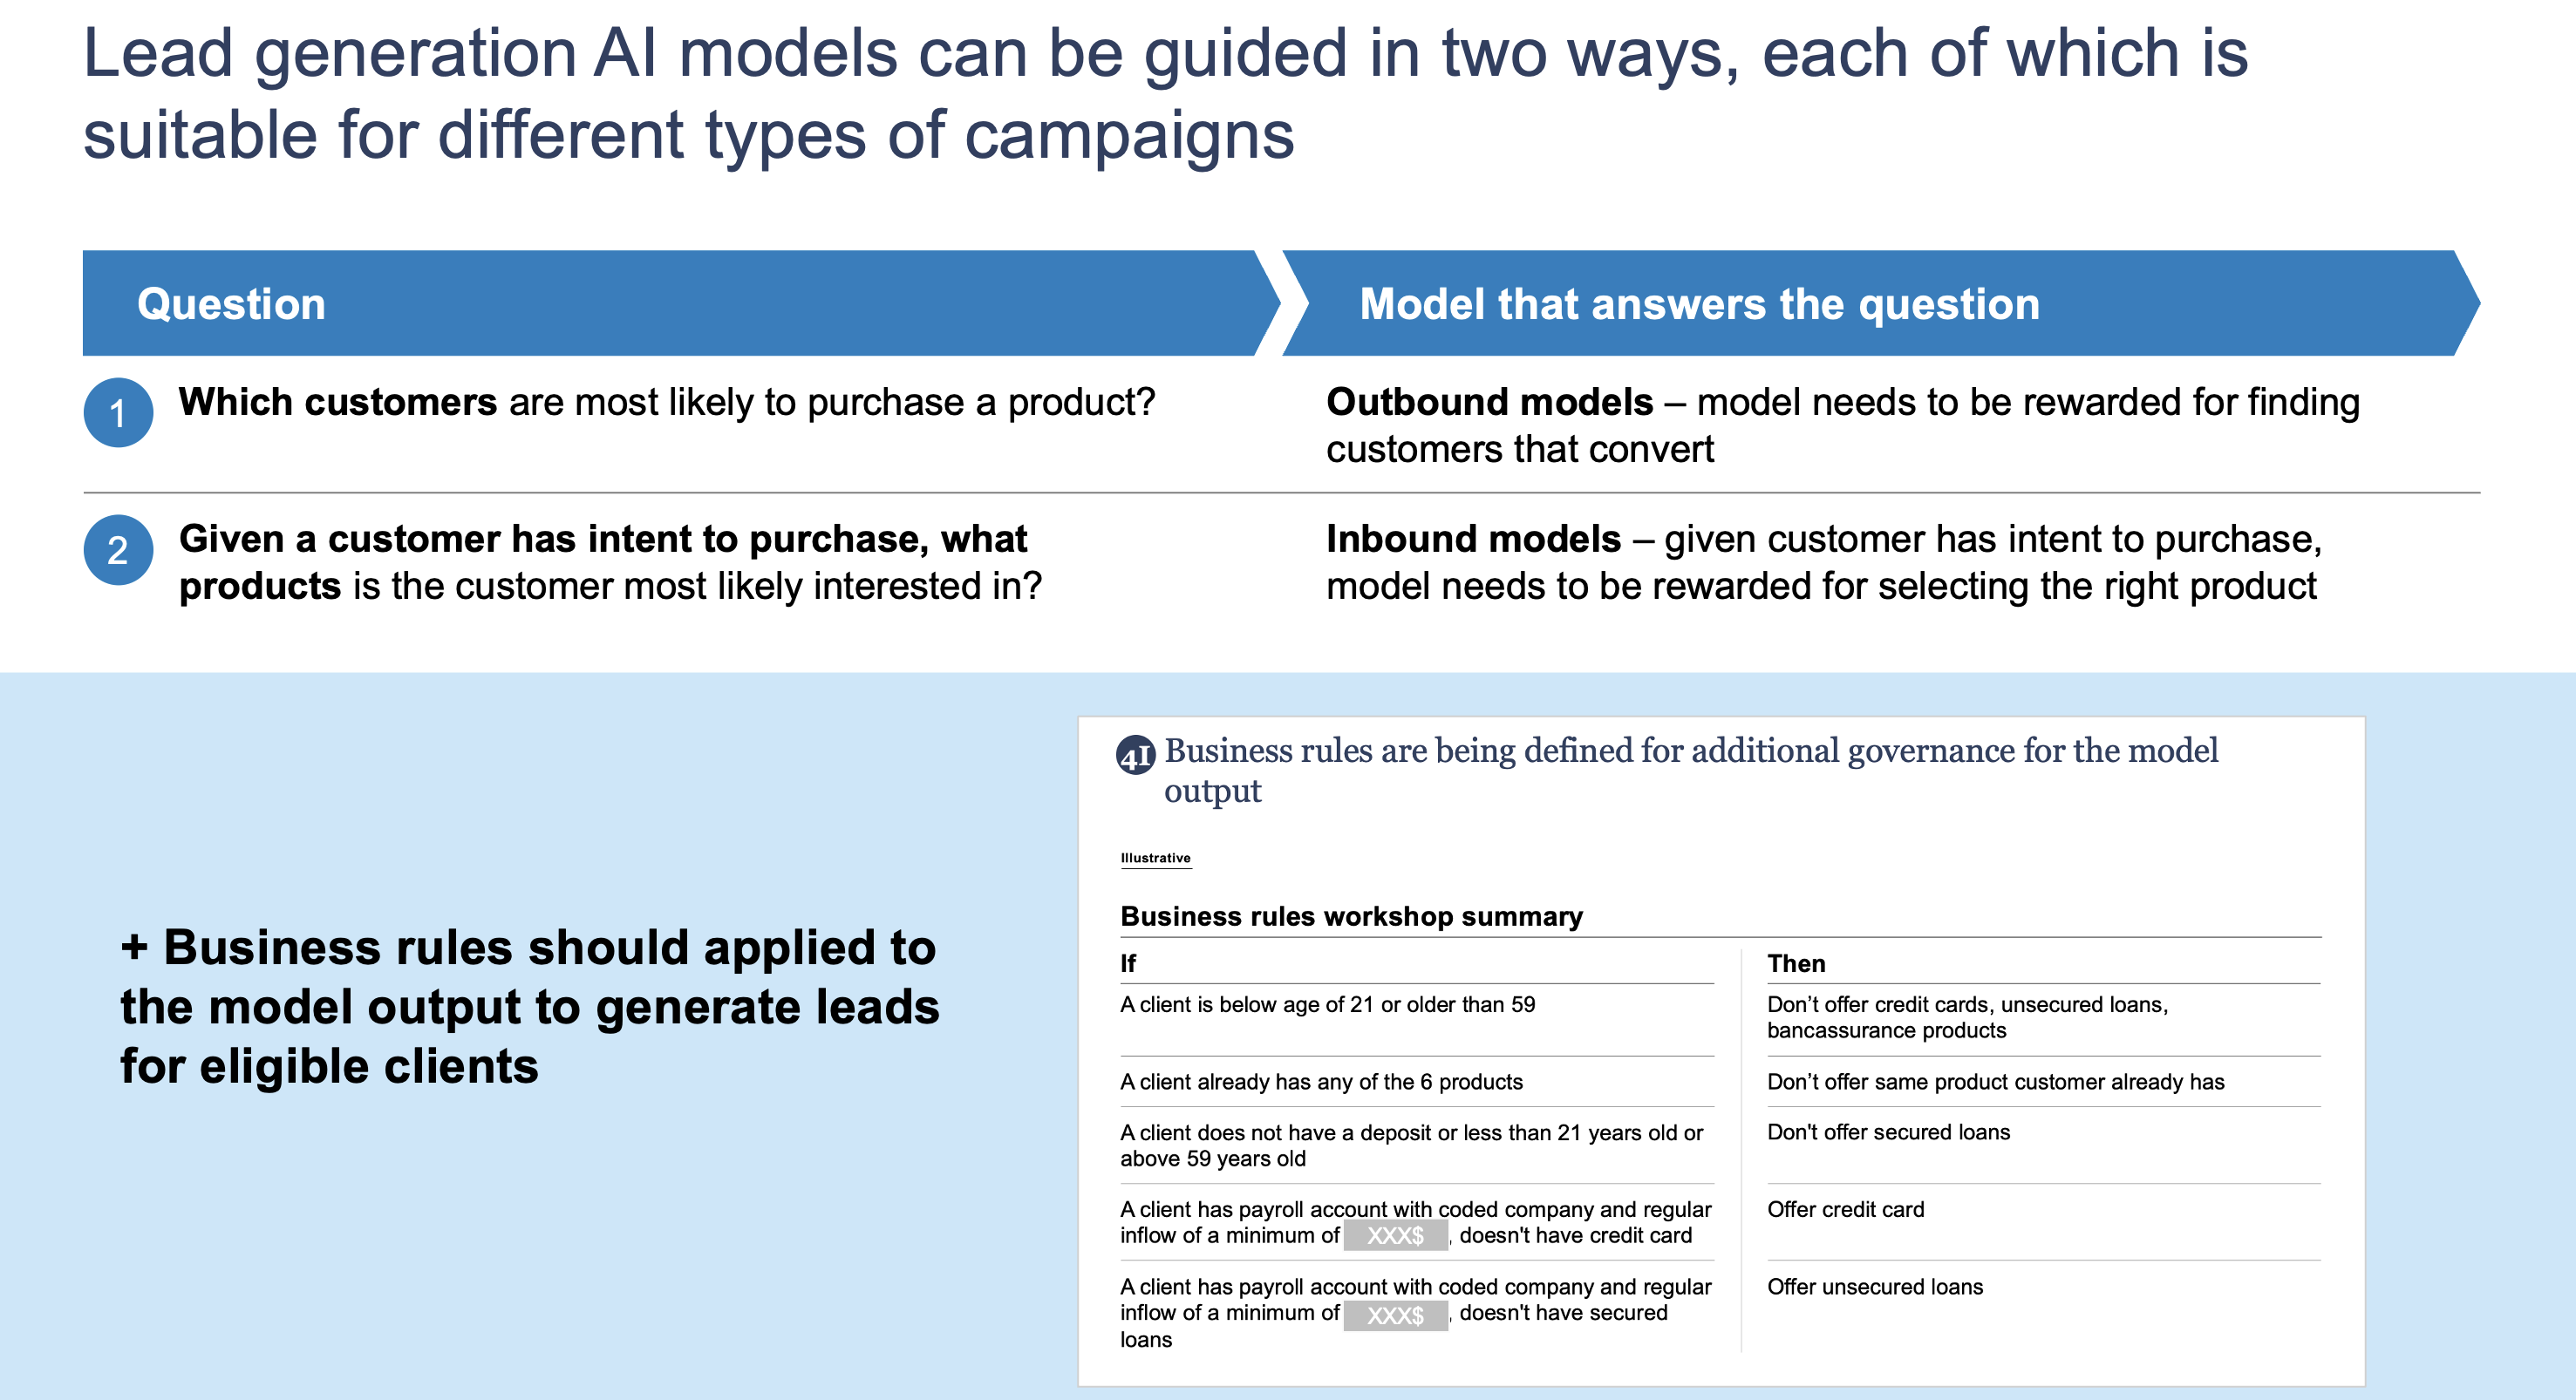

In [10]:
Image(filename='models.png')

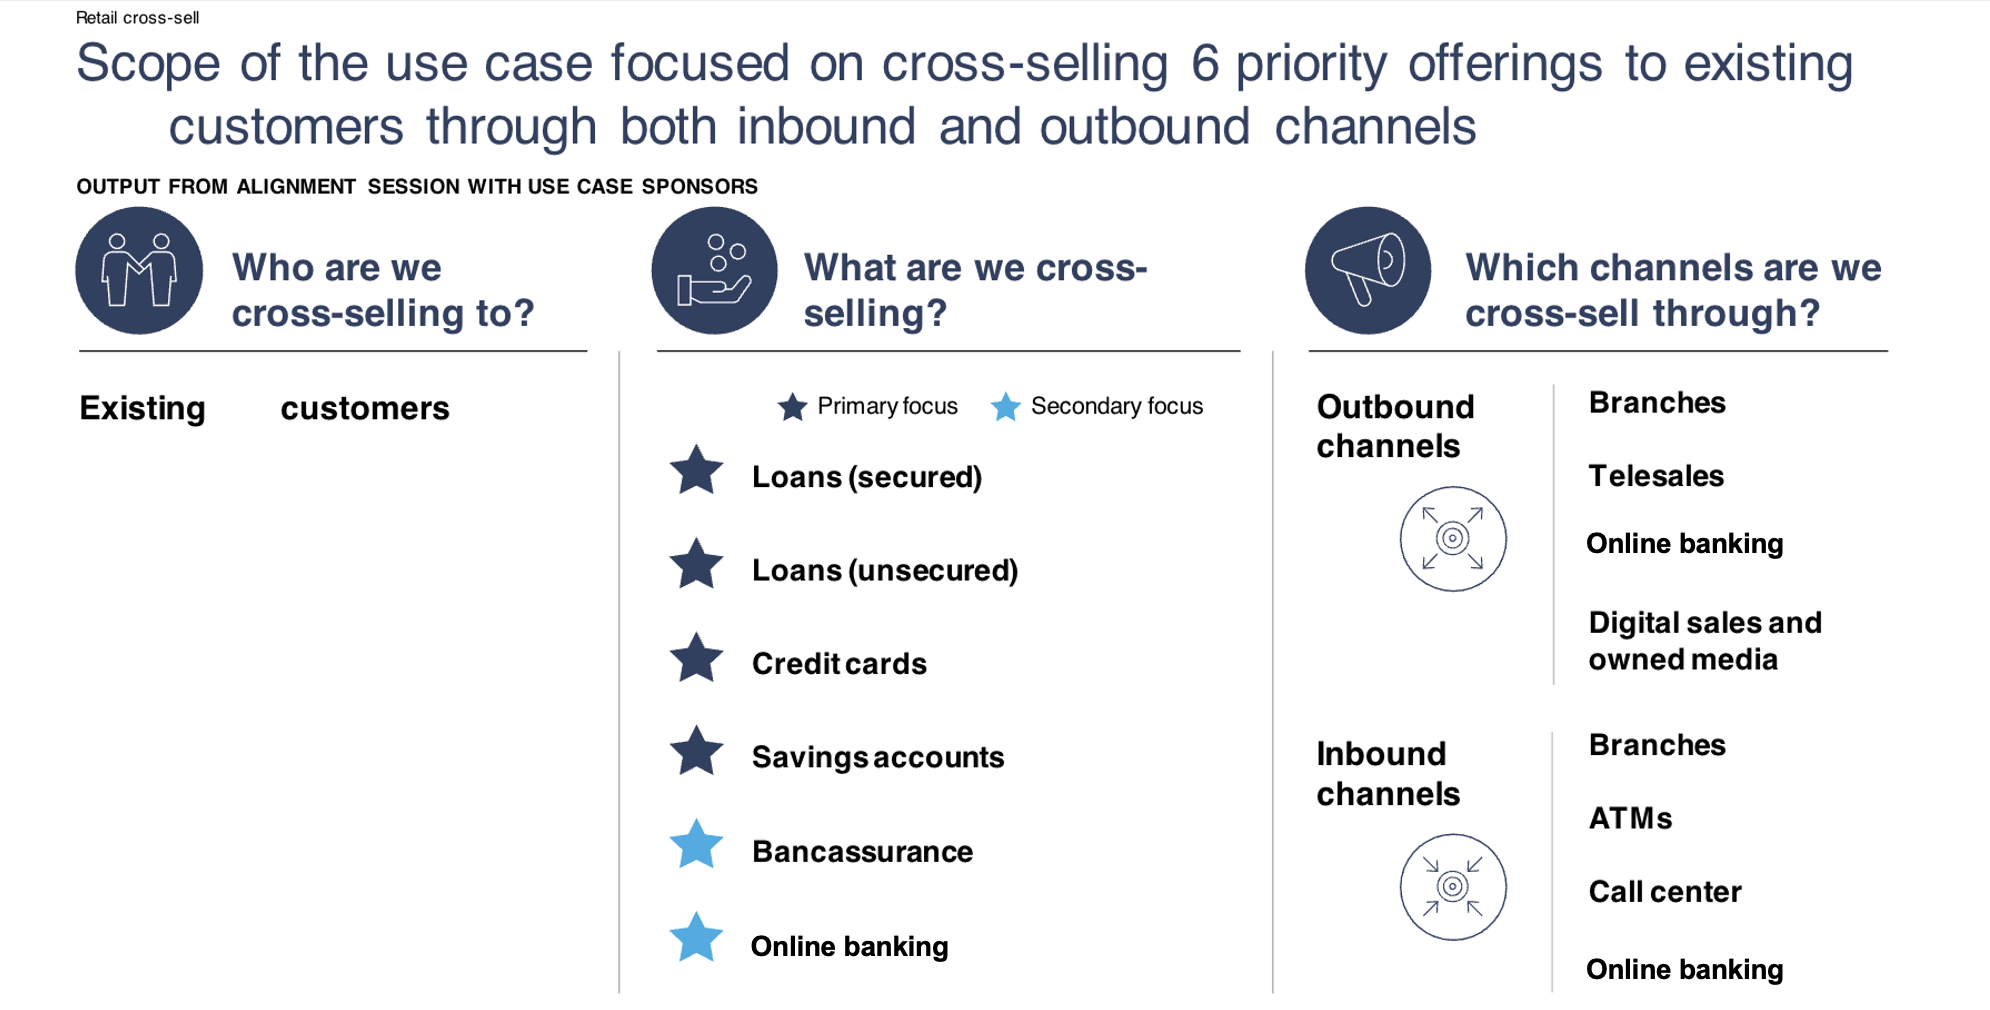

In [9]:
Image(filename='scope.png')

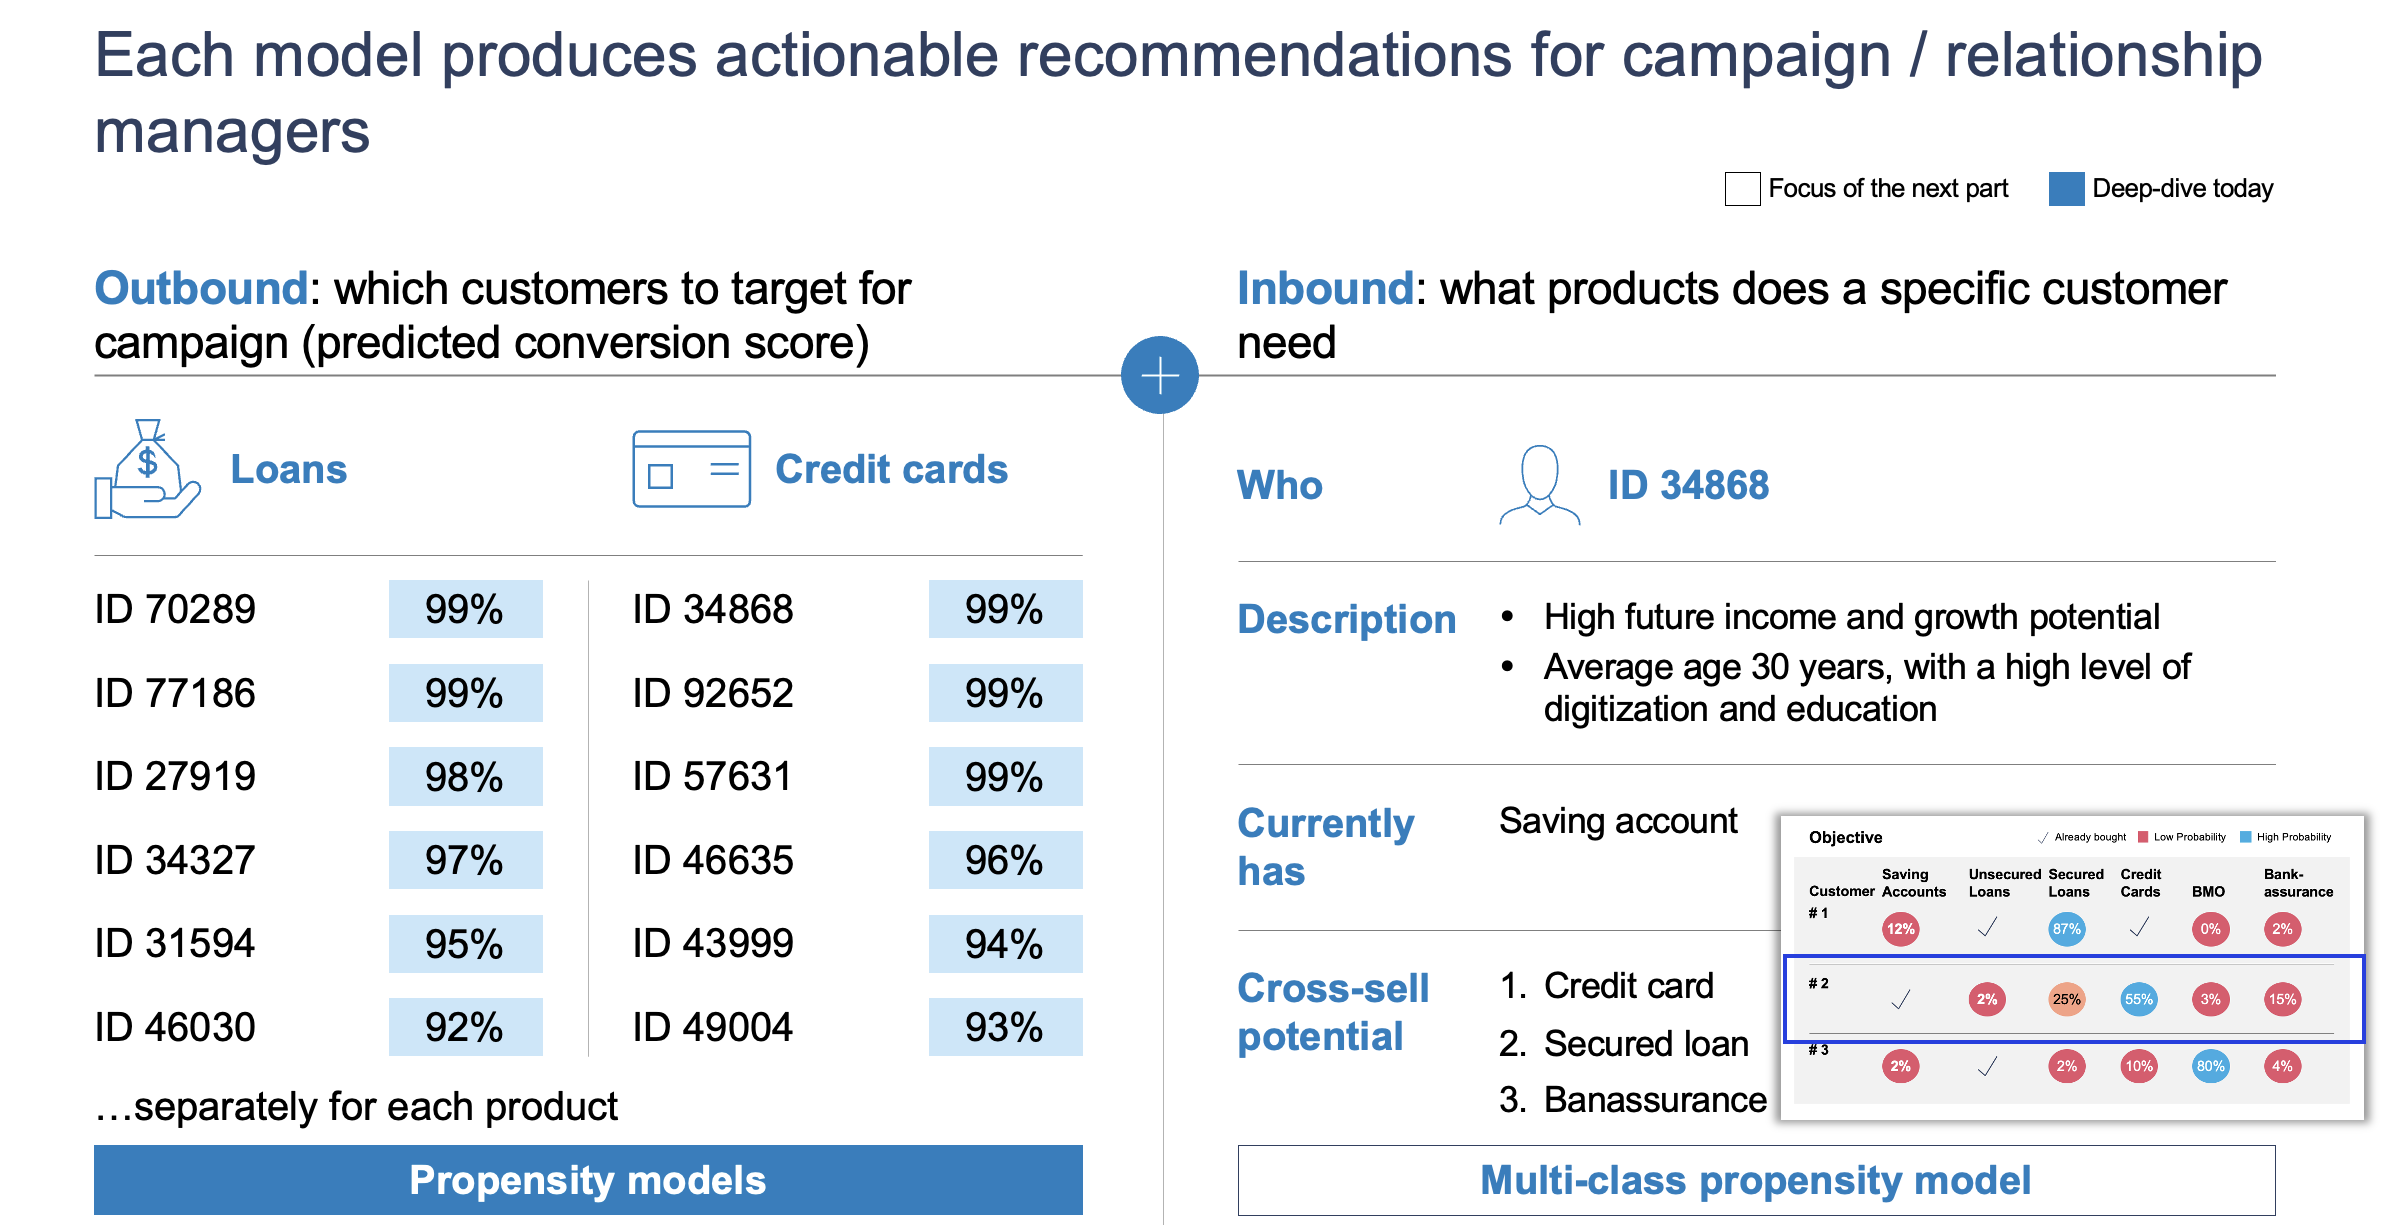

In [13]:
Image(filename='models_details.png')

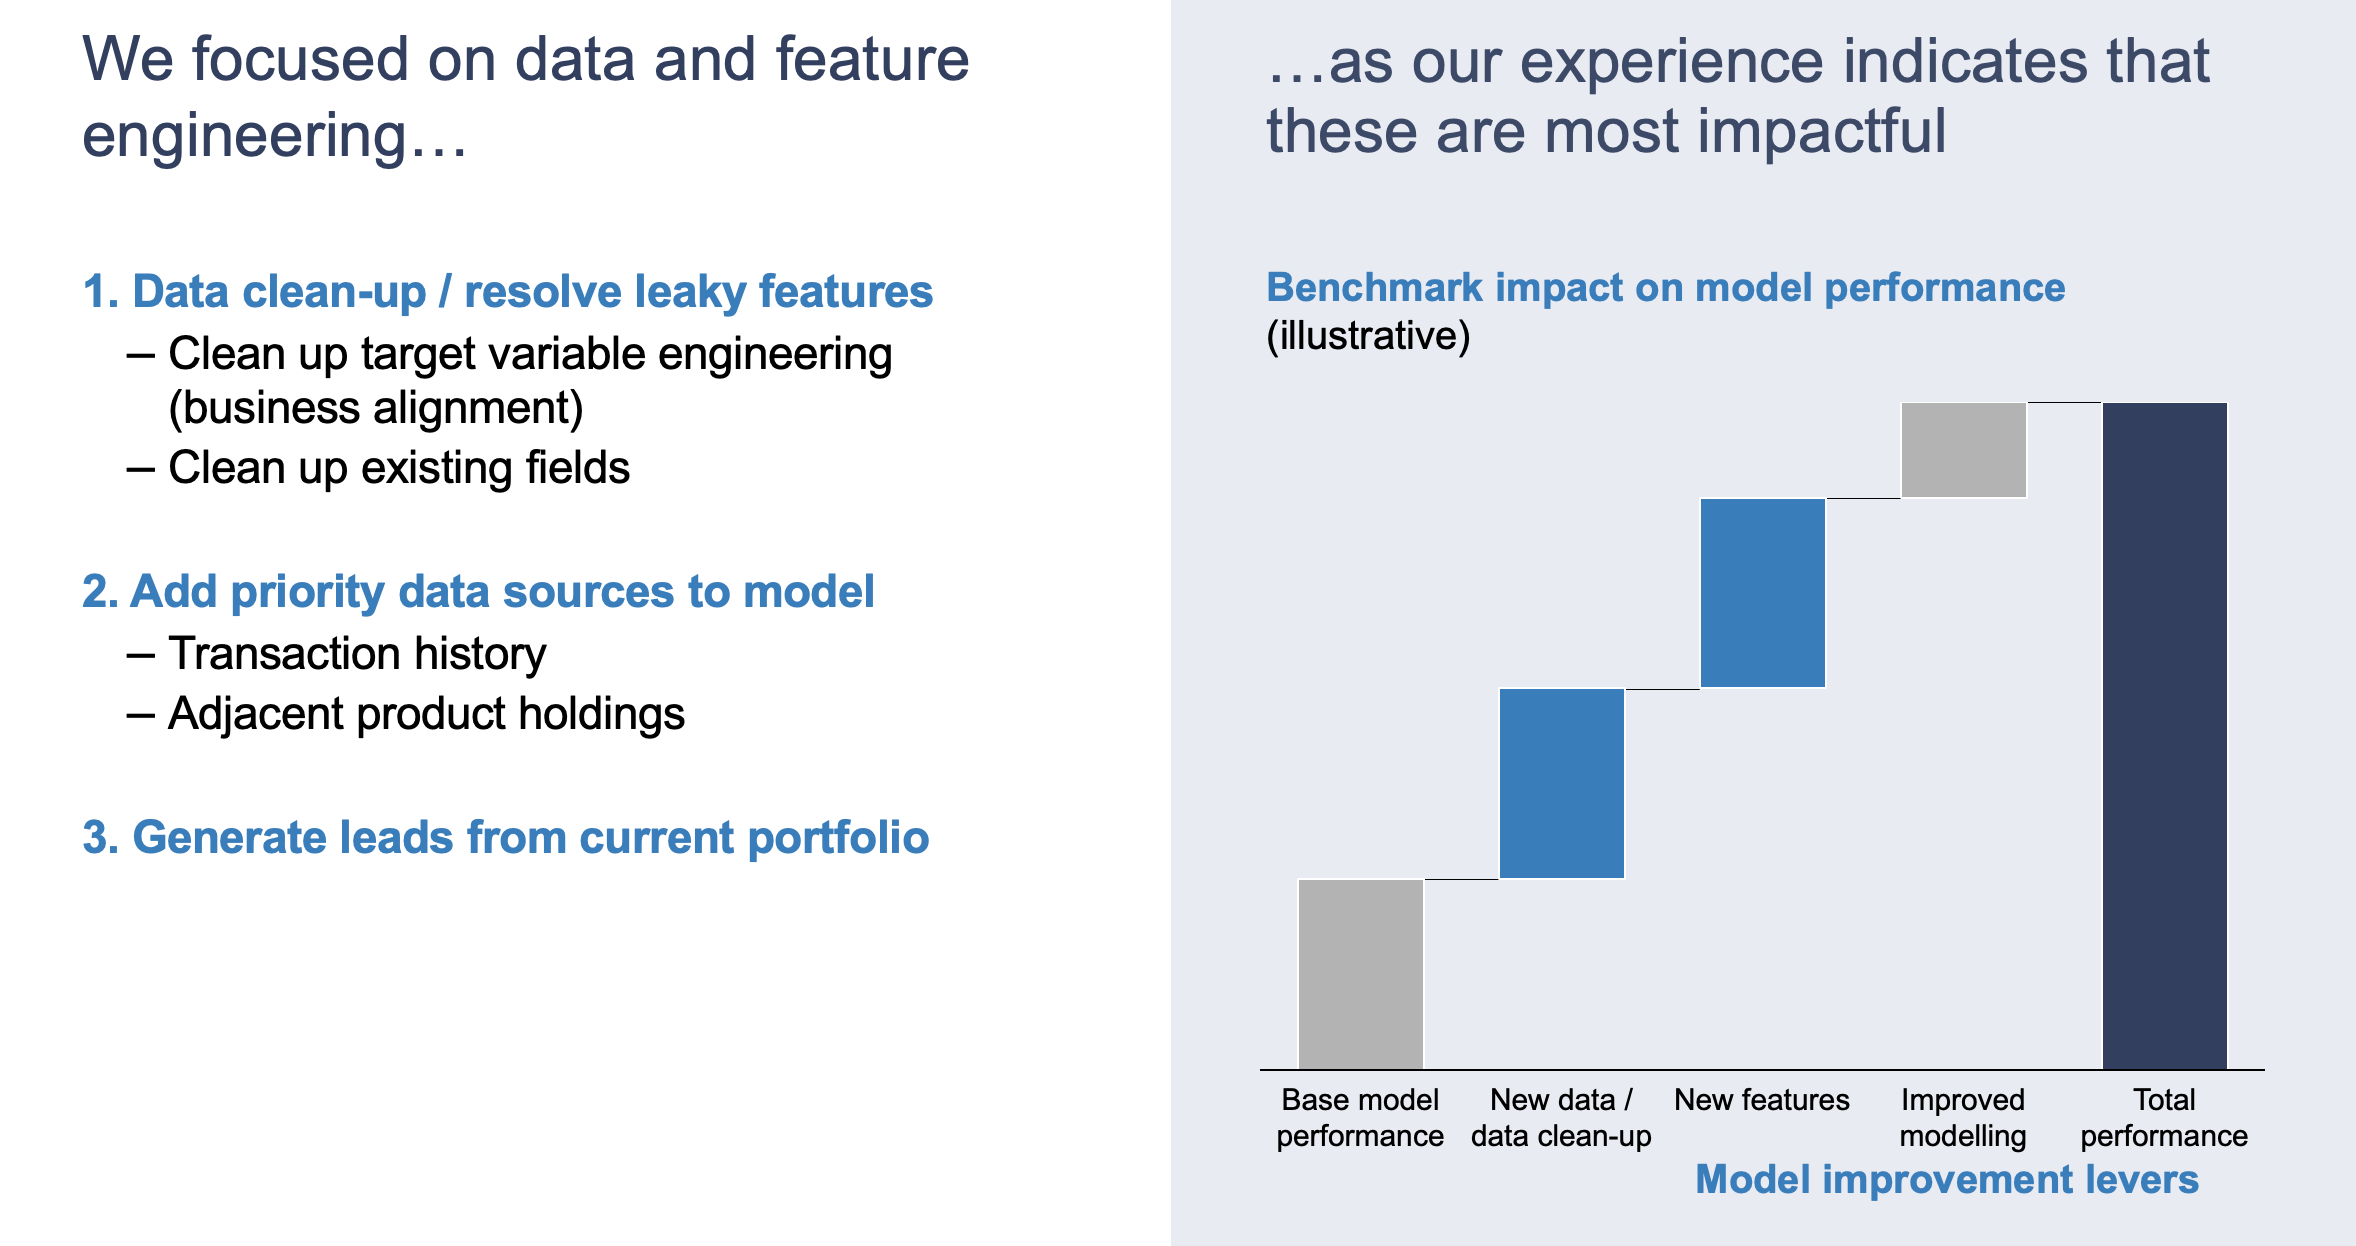

In [32]:
Image(filename='process.png')

#### 1.2. Challenges

| N | Description                                                                                                                                                                                                | Eliminanion                                                                                                                                               |
|---|------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|-----------------------------------------------------------------------------------------------------------------------------------------------------------|
| 1 | Structure: Raw data is poorly organized                                                                                                                                                                    | Step-by-step structure of every raw data source processing; configuration file.                                                                           |
| 2 | Data Quality: dozens of data sources + lack of its knowledge + a lot of quality issues                                                                                                                     | Checks added at every stage of the process: N of missing values, all possible aggregated checks & continuous control that all final values are correct.   |
| 3 | Technical restrictions: code in Zeppelin notebooks on local PC's only, two environments - %python and %pyspark, where not all libraries ara availble inside. %python contain python 2.X version installed. | Specifics of some code lines.                                                                                                                             |

## 2. X-sell approach

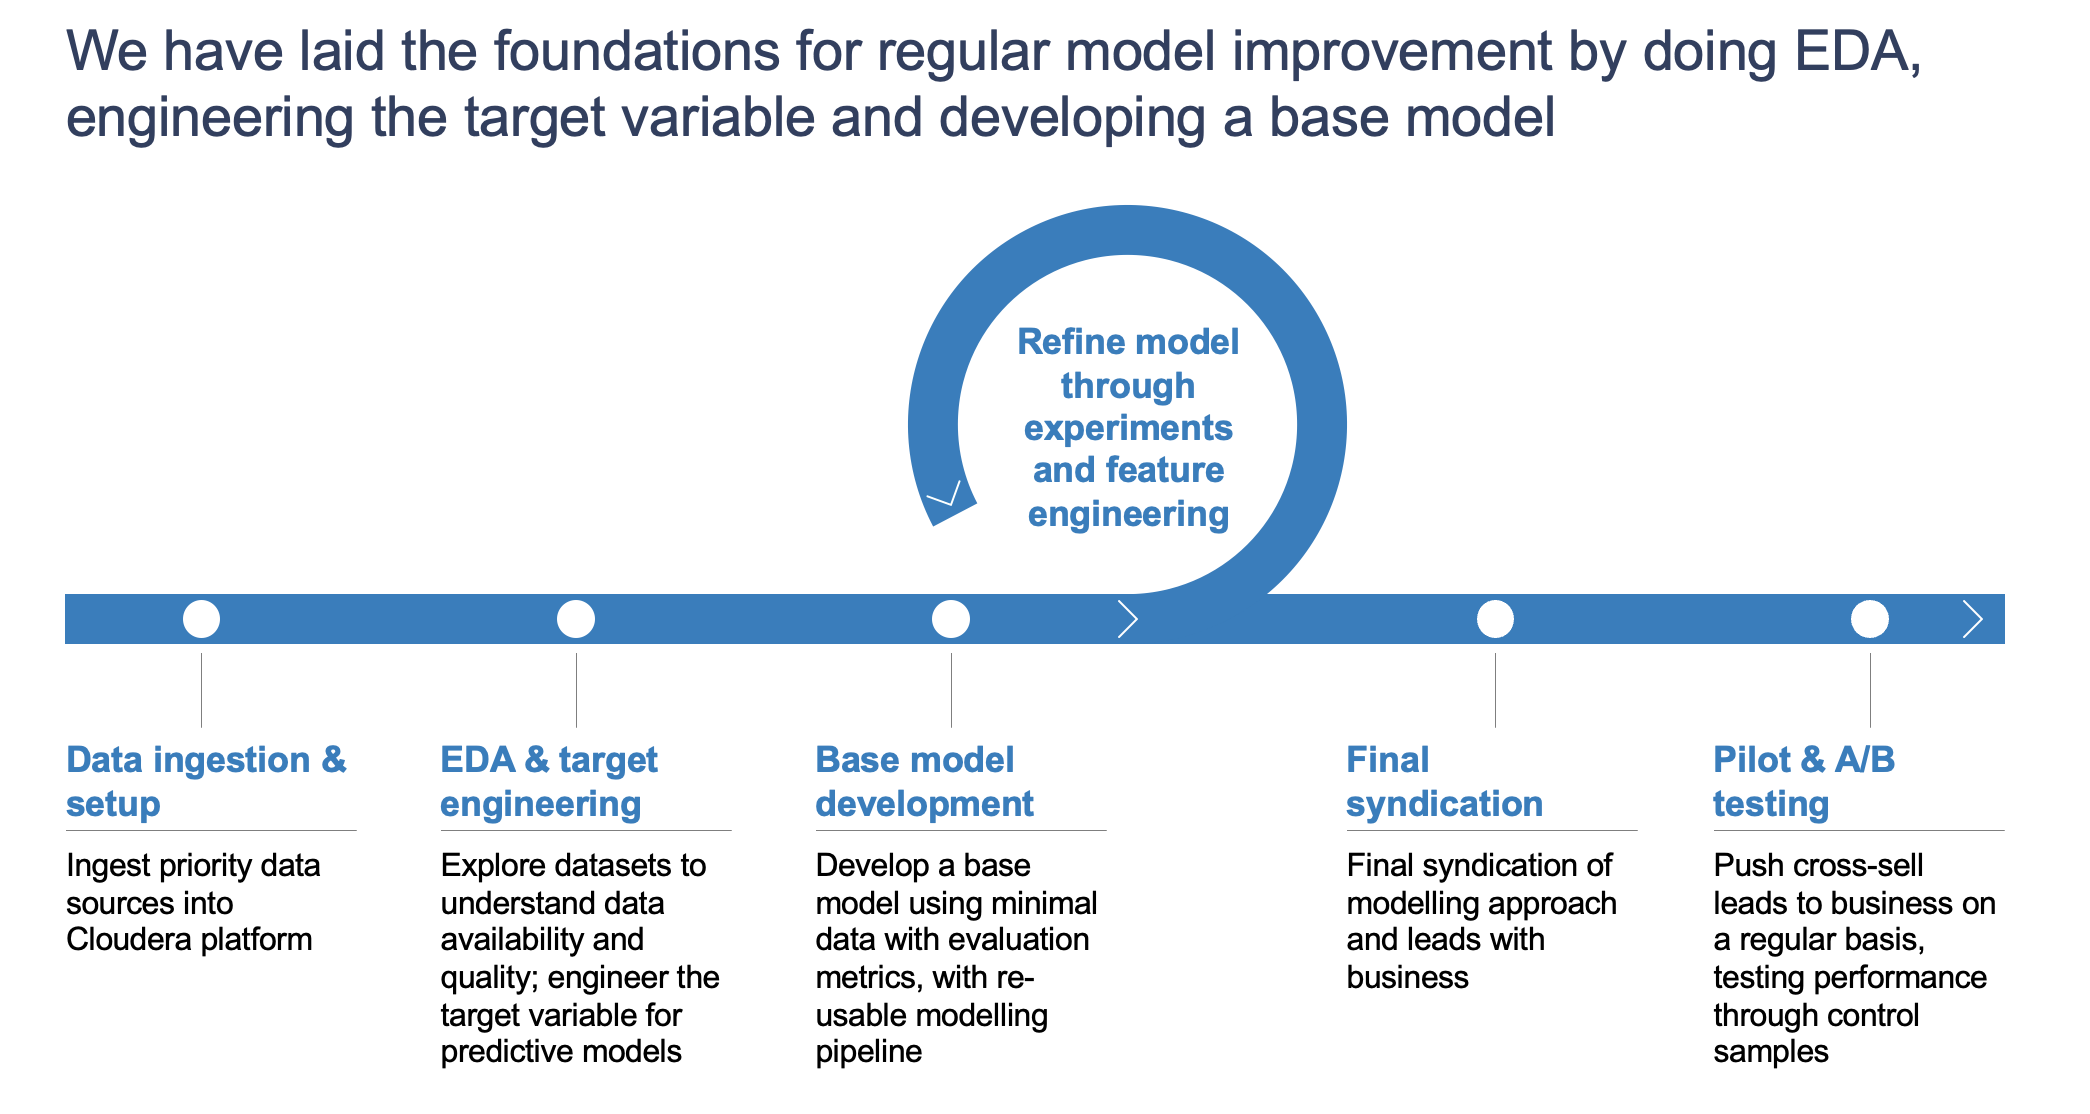

In [11]:
Image(filename='approach_structure.png')

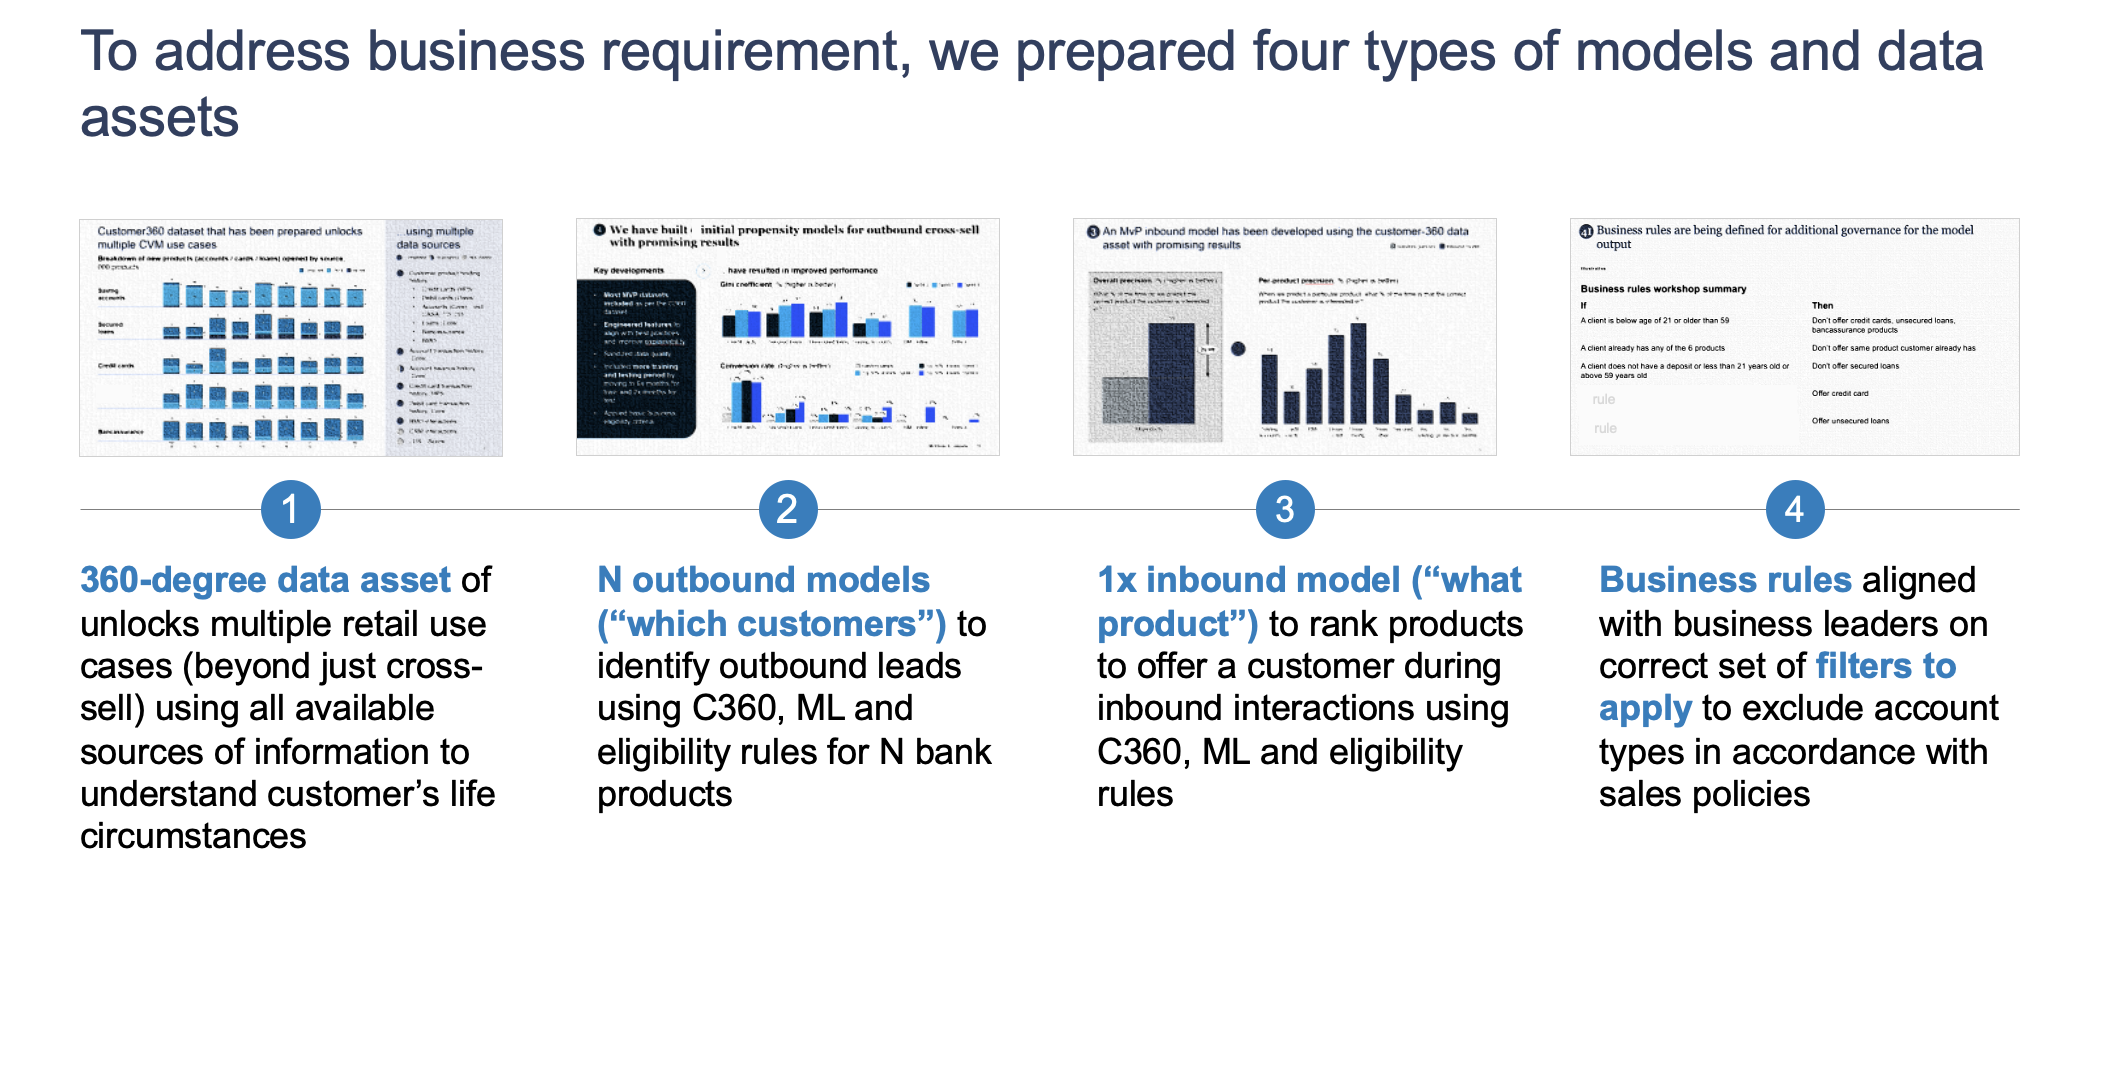

In [12]:
Image(filename='assets.png')

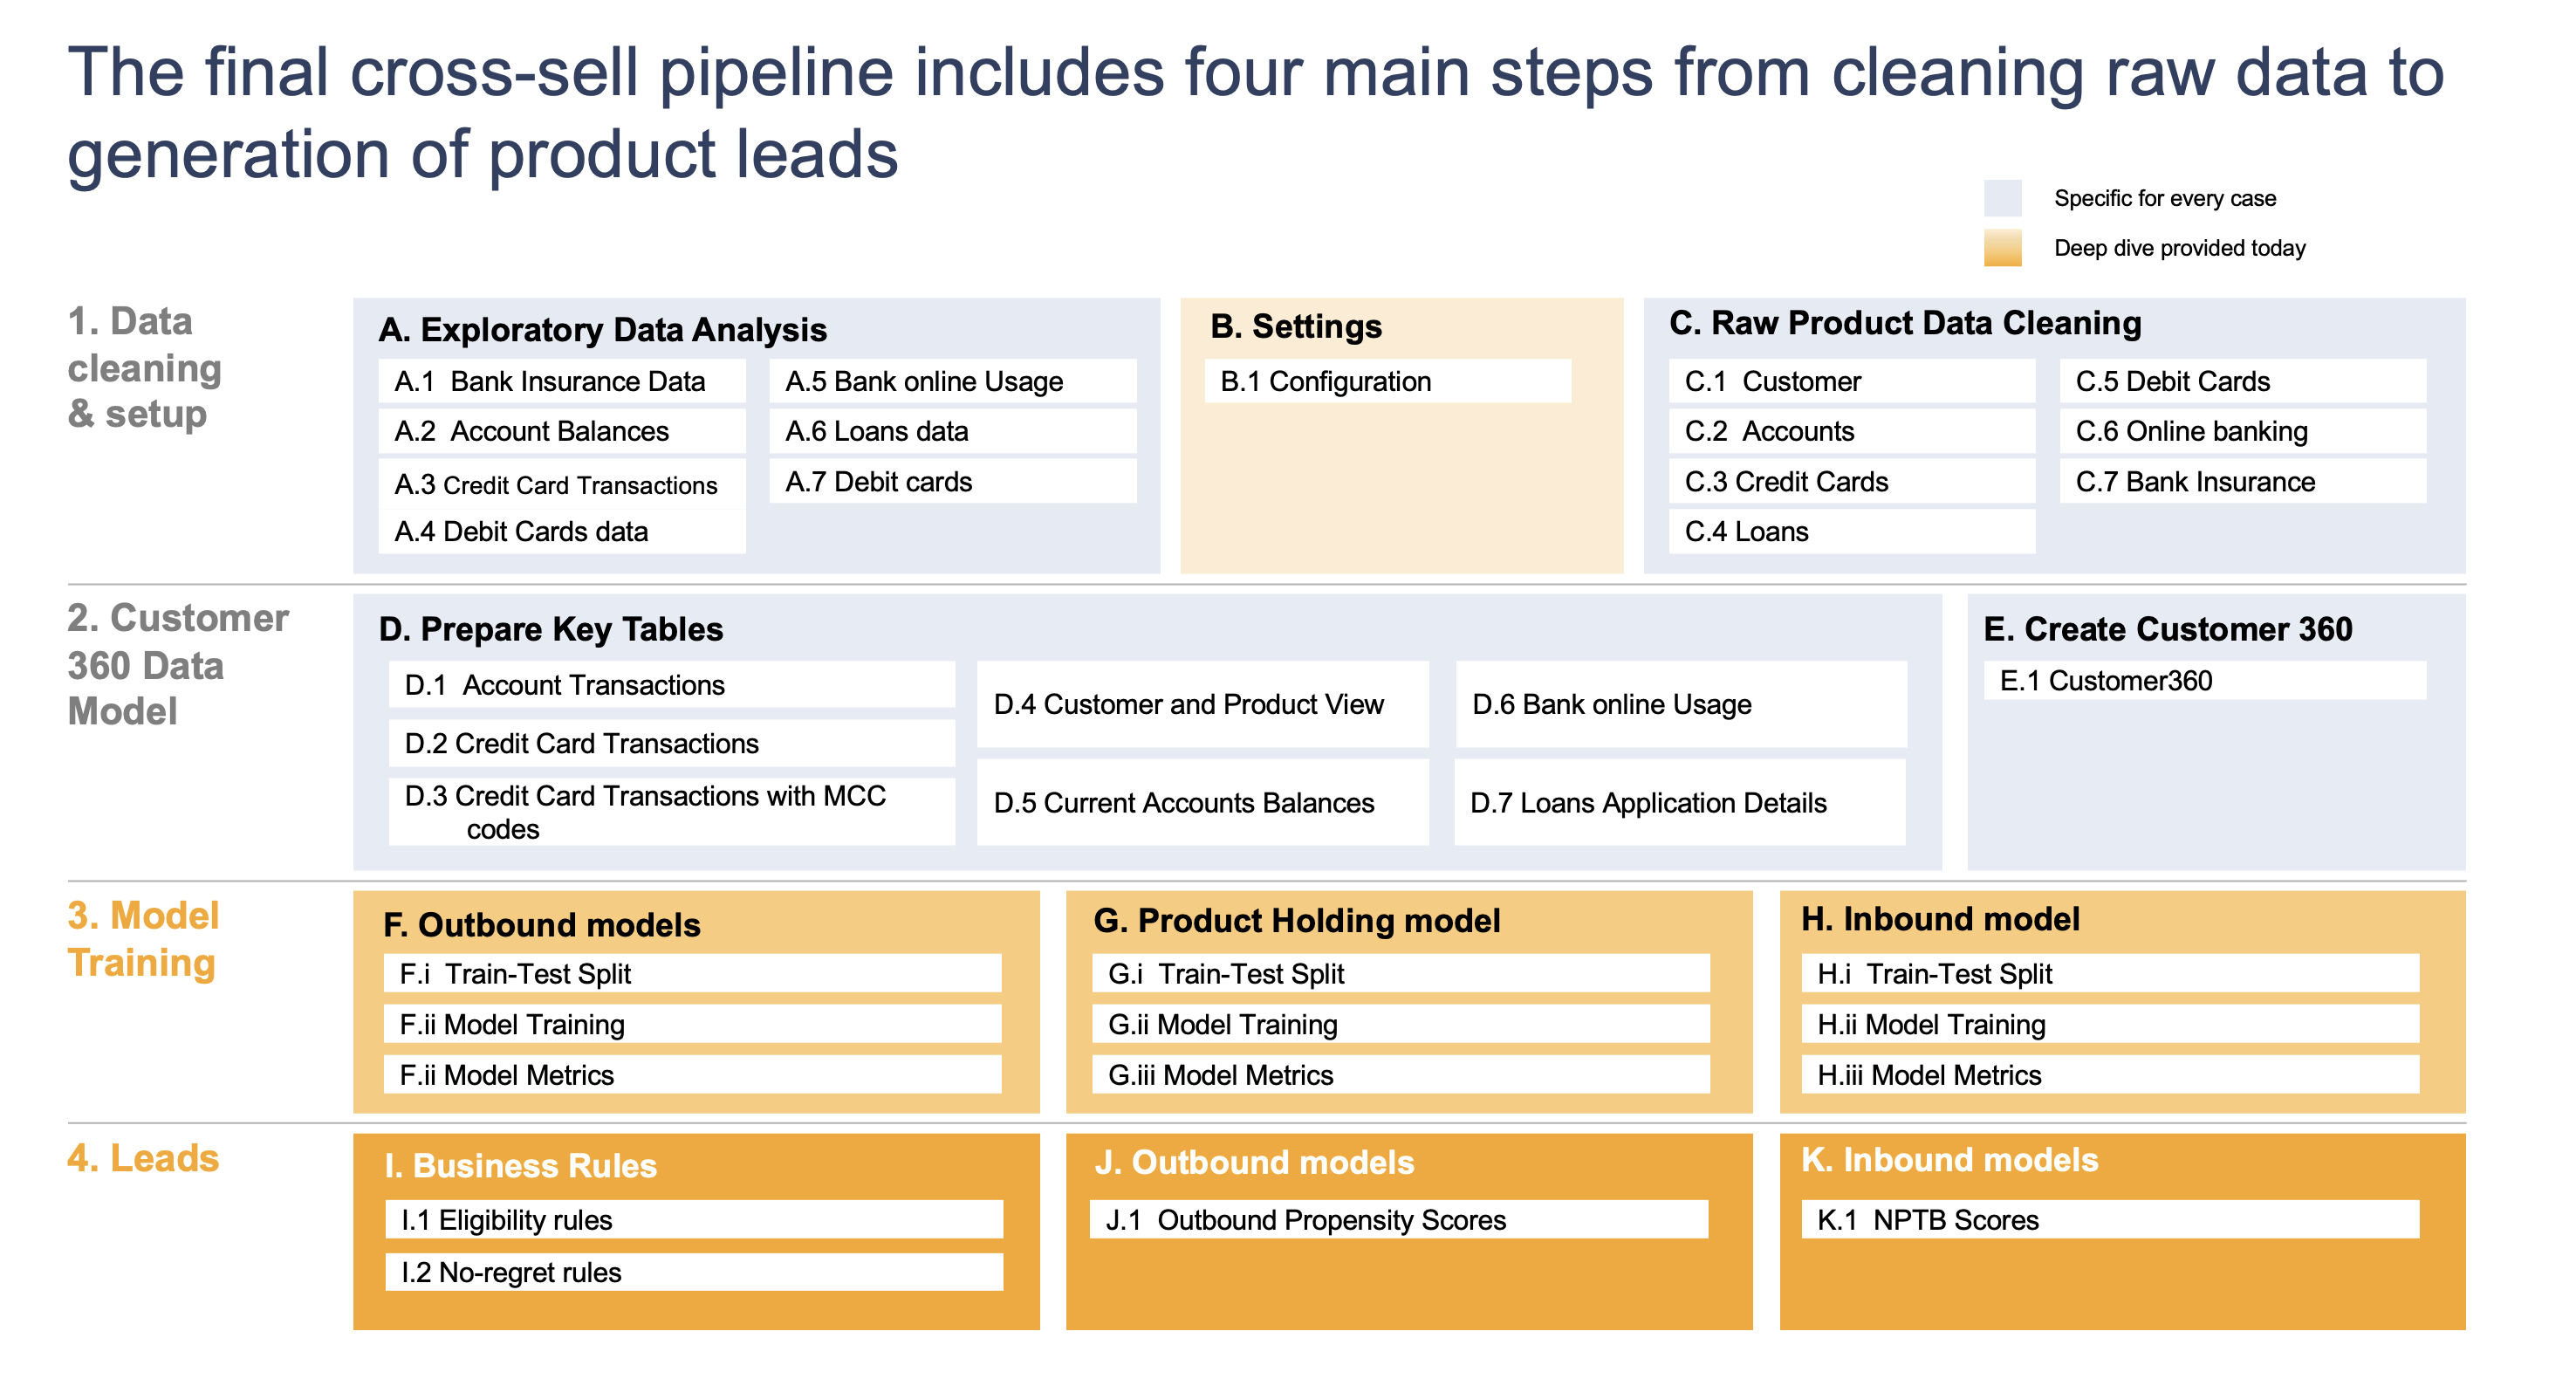

In [29]:
Image(filename='pipeline.png')

## 2 | 1. Data cleaning & setup
### B.1 Configuration Settings

<style>
    .custom-list {
        list-style-type: disc; /* Use disc bullets */
        color: #686868; /* Set the color for the bullets */
        margin-left: 20px; /* Add left indentation */
    }
    .custom-text {
        color: #686868; /* Set the color for the text */
    }
</style>

<p><span style='color: #686868;'> Let us set date ranges for all further steps of the data preparation process:</p></span></li>
<ul class="custom-list">
    <li><span style='color: #67738C; font-weight: bold;'>model version prefix:</span>  <span style='color: #686868;'>for model versioning</span></li>
    <li><span style='color: #67738C; font-weight: bold;'>time_series_prep_sdate, time_series_prep_edate:</span> <span style='color: #686868;'>customer 360 preparation dates</span></li>
    <li><span style='color: #67738C; font-weight: bold;'>train_start_date, train_end_date:</span> <span style='color: #686868;'>model training periods</span></li>
    <li><span style='color: #67738C; font-weight: bold;'>test_start_date, test_end_date:</span> <span style='color: #686868;'>model testing periods (OOT sample)</span></li>
    <li><span style='color: #67738C; font-weight: bold;'>scoring period (for leads):</span> <span style='color: #686868;'>score_date</span></li>
</ul>

In [63]:
# All output files will be prefixed by this
model_version_prefix = "20230717"

# The customer 360 view will be prepared using this range
time_series_prep_sdate = "2021-04-01"
time_series_prep_edate = "2023-09-14"

# Model trained on this range
train_start_date = "2022-06-01"
train_end_date = "2023-06-01"

# Model tested on this range
test_start_date = "2023-07-01"
test_end_date = "2023-09-01"

# Model scored on this range
score_date = "2023-10-01"

# Save as a spark table so we can read in other places
schema = [
    "time_series_prep_sdate",
    "time_series_prep_edate",
    "train_start_date",
    "train_end_date",
    "test_start_date",
    "test_end_date",
    "score_date",
    "model_version_prefix",
]

values = [(
    time_series_prep_sdate,
    time_series_prep_edate,
    train_start_date,
    train_end_date,
    test_start_date,
    test_end_date,
    score_date,
    model_version_prefix,
)]

config = spark.createDataFrame(data=values, schema=schema)
#config.write.mode('overwrite').saveAsTable("db.xs0_config")
config.show()

config.write.mode('overwrite').parquet("xs0_config.parquet")

#spark.table("db.xs0_config").show()

+----------------------+----------------------+----------------+--------------+---------------+-------------+----------+--------------------+
|time_series_prep_sdate|time_series_prep_edate|train_start_date|train_end_date|test_start_date|test_end_date|score_date|model_version_prefix|
+----------------------+----------------------+----------------+--------------+---------------+-------------+----------+--------------------+
|            2021-04-01|            2023-09-14|      2022-06-01|    2023-06-01|     2023-07-01|   2023-09-01|2023-10-01|            20230717|
+----------------------+----------------------+----------------+--------------+---------------+-------------+----------+--------------------+



## 2.1 Customer 360

<style>
    .custom-list {
        list-style-type: none; /* Remove default bullets */
        padding-left: 0; /* Remove left indentation */
    }

    .custom-list li:before {
        content: "•"; /* Use a custom bullet character, such as a black dot • */
        color: #686868; /* Set the color for the bullet */
        font-weight: bold; /* Set the font weight for the bullet */
        padding-right: 5px; /* Add some space between the bullet and text */
    }
</style>

<span style='color: #67738C; font-weight: bold;'>Customer360 dataset that has been prepared unlocks multiple CVM use cases...:<span>
<ul class="custom-list">
    <li style="color: #686868;">Cross-sell (outbound + inbound)</li>
    <li style="color: #686868;">Churn prediction</li>
    <li style="color: #686868;">Up-sell</li>
</ul>

<span style='color: #67738C; font-weight: bold;'>...using multiple data sources:<span>
<ul class="custom-list">
    <li style="color: #686868;">Customer product holding history:</li>
    <li style="color: #686868;">Credit cards</li>
    <li style="color: #686868;">Debit cards</li>
    <li style="color: #686868;">Accounts</li>
    <li style="color: #686868;">Loans</li>
    <li style="color: #686868;">Bancassurance</li>
    <li style="color: #686868;">Online banking</li>
    <li style="color: #686868;">Account transaction history</li>
    <li style="color: #686868;">Account balance history</li>
    <li style="color: #686868;">Credit card transaction history</li>
    <li style="color: #686868;">Debit card transaction history</li>
    <li style="color: #686868;">Bank online interactions</li>
    <li style="color: #686868;">CRM interactions</li>
    <li style="color: #686868;">Credit history data</li>
</ul>


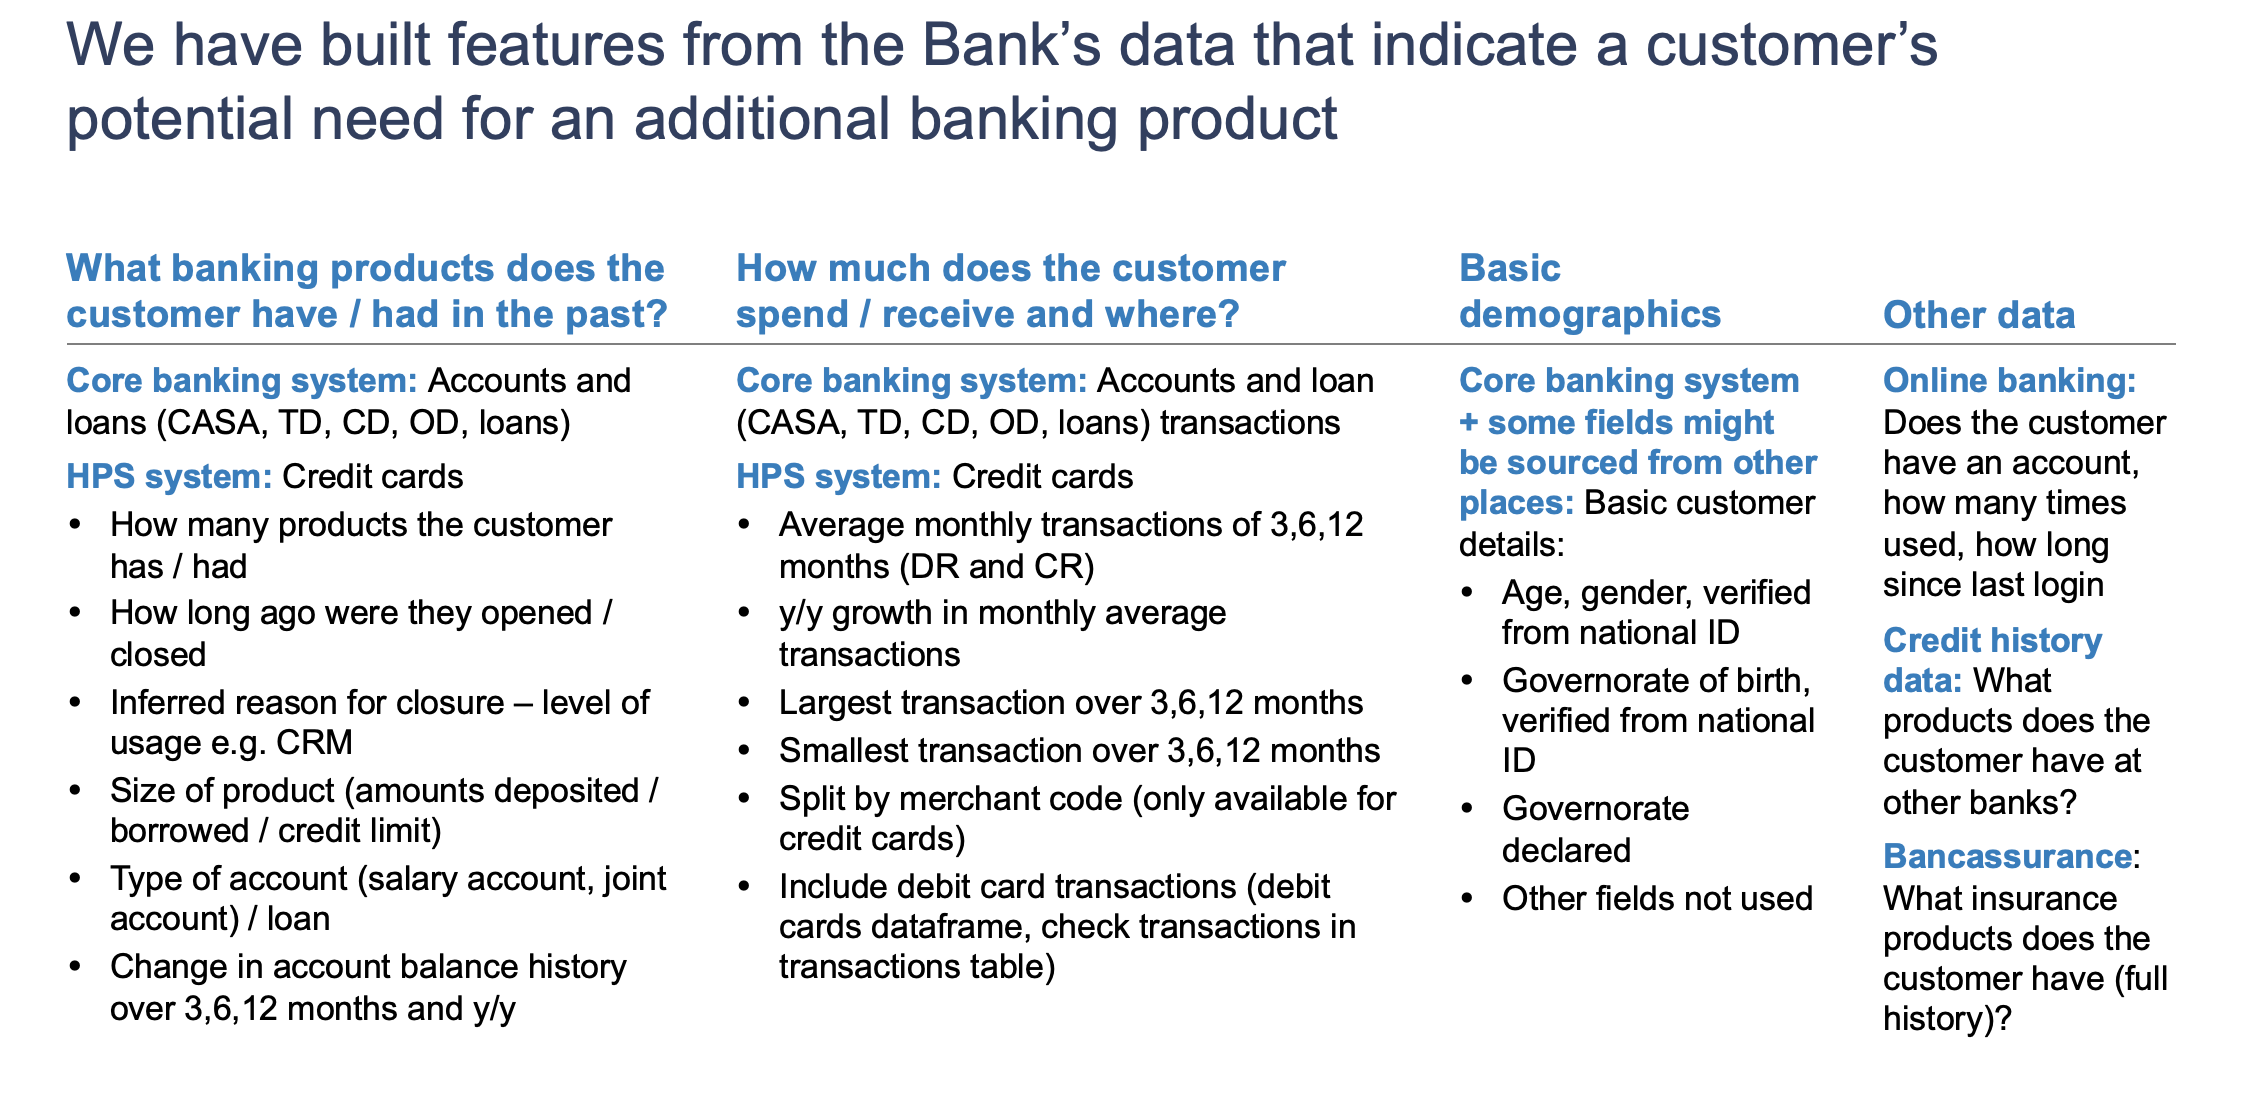

In [61]:
Image(filename='features_description.png')

#### 2.1.1 Data: Generate synthetic dataset

As soon as we cannot use the origincal dataset, let's generate synthetic version of Customer 360 for further code testing

In [59]:
import pandas as pd
import random
from datetime import datetime, timedelta

# Define the number of observations
num_observations = 100000

# Generate random dates within a specific range
def random_date(start_date, end_date):
    time_between_dates = end_date - start_date
    days_between_dates = time_between_dates.days
    random_number_of_days = random.randrange(days_between_dates)
    random_date = start_date + timedelta(days=random_number_of_days)
    return random_date

# Generate data
data = []

for _ in range(num_observations):
    start_date = datetime(2020, 1, 1)
    end_date = datetime(2023, 1, 1)
    date_range = f"{random_date(start_date, end_date)} - {random_date(start_date, end_date)}"
    model_version_prefix = model_version_prefix 
    
    data.append([date_range, model_version_prefix])

# Create a DataFrame
customer360 = pd.DataFrame(data, columns=["Date Range", "Model Version Prefix"])

# Display the DataFrame
print(customer360)

                                      Date Range Model Version Prefix
0      2020-10-24 00:00:00 - 2021-12-16 00:00:00             20230717
1      2021-10-17 00:00:00 - 2021-03-31 00:00:00             20230717
2      2020-03-25 00:00:00 - 2022-04-05 00:00:00             20230717
3      2022-07-14 00:00:00 - 2020-11-16 00:00:00             20230717
4      2020-06-23 00:00:00 - 2020-11-13 00:00:00             20230717
...                                          ...                  ...
99995  2020-12-29 00:00:00 - 2020-02-02 00:00:00             20230717
99996  2021-12-26 00:00:00 - 2022-09-05 00:00:00             20230717
99997  2021-04-20 00:00:00 - 2020-05-09 00:00:00             20230717
99998  2020-07-05 00:00:00 - 2020-01-14 00:00:00             20230717
99999  2022-07-09 00:00:00 - 2020-01-07 00:00:00             20230717

[100000 rows x 2 columns]


## 2.2 Outbound models

In [64]:
# ==========================================
# Load config
# ==========================================

#config = spark.table("db.xs0_config")

config = spark.read.parquet('xs0_config.parquet')

time_series_prep_sdate = config.collect()[0][0]
time_series_prep_sdate = config.collect()[0][0]
time_series_prep_edate = config.collect()[0][1]
train_start_date = config.collect()[0][2]
train_end_date = config.collect()[0][3]
test_start_date = config.collect()[0][4]
test_end_date = config.collect()[0][5]
score_date = config.collect()[0][6]
model_version_prefix = config.collect()[0][7]

config.show()

+----------------------+----------------------+----------------+--------------+---------------+-------------+----------+--------------------+
|time_series_prep_sdate|time_series_prep_edate|train_start_date|train_end_date|test_start_date|test_end_date|score_date|model_version_prefix|
+----------------------+----------------------+----------------+--------------+---------------+-------------+----------+--------------------+
|            2021-04-01|            2023-09-14|      2022-06-01|    2023-06-01|     2023-07-01|   2023-09-01|2023-10-01|            20230717|
+----------------------+----------------------+----------------+--------------+---------------+-------------+----------+--------------------+



In [54]:
models = [
    "saving_account",
    "unsecured_loans",
    "secured_loans",
    "credit_cards",
    "bank_online",
    "bank_insurance"
]

In [ ]:
#Insert latest version of Customer360 view 

#original line:
#customer360 = spark.table("db.xs2_2_xproduct_modelling_dataset_partitioned_"+model_version_prefix)

#test line:
customer360

customer360.show(n=1,vertical=True)

# DRAFT BELOW (JUST ADDED THE RAW CODE TO UPDATE IT FURTHER)

### 2.2.1 Train Test Split

In [ ]:
import sys
import os
import subprocess

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession, HiveContext ,Row
from pyspark.sql import functions as F
from datetime import date
from dateutil.relativedelta import relativedelta



spark = SparkSession.builder.appName("test_1")\
                            .config("spark.sql.catalogImplementation","hive")\
                            .config("spark.sql.caseSensitive", "false")\
                            .config("hive.exec.dynamic.partition", "true")\
                            .config("hive.exec.dynamic.partition.mode", "nonstrict")\
                            .config("spark.sql.htl.check", "false")\
                            .config("spark.sql.warehouse.dir", "\landing_zone\hps")\
                            .enableHiveSupport()\
                            .master("yarn").getOrCreate()


spark.sql("use staging_zone")

# ==========================================
# Load config
# ==========================================

config = spark.table("analyatics_zone.xs0_config")

time_series_prep_sdate = config.collect()[0][0]
time_series_prep_sdate = config.collect()[0][0]
time_series_prep_edate = config.collect()[0][1]
train_start_date = config.collect()[0][2]
train_end_date = config.collect()[0][3]
test_start_date = config.collect()[0][4]
test_end_date = config.collect()[0][5]
score_date = config.collect()[0][6]
model_version_prefix = config.collect()[0][7]

config.show()

models = [
    "savacc",
    "unsecured_loans",
    "secured_loans",
    "credit_cards",
    "BMO",
    "bank_insurance"
]


#Insert latest version of Customer360 view from Step2_Customer_360TS_DataModel/2_2_PrepareCustomer360
customer360 = spark.table("analyatics_zone.xs2_2_xproduct_modelling_dataset_partitioned_"+model_version_prefix)

customer360.show(n=1,vertical=True)

## Prepare Train Datasets

# 1) Filter to include only requried customers (active and did not have product at SOP) and create the indicator column
# 2) Filter to include only the required periods
# 3) Up sample for train
# 4) Random sample for test
import datetime as dt

current_date = dt.datetime.now().strftime("yyMMdd")

# 1) Filter to include only requried customers (active and did not have product at SOP) and create the indicator column
df = customer360.filter(
        (F.col("customer___active_SOP") == F.lit(1)) &\
        (F.col("tenure") >= F.lit(3/12))
    )

df_all_train = df.filter(
        (F.col("__PERIOD") >= F.lit(train_start_date)) &\
        (F.col("__PERIOD") <= F.lit(train_end_date))
    ).cache()

for p in models:
    
    # 3) Up sample for train
    df_train = df_all_train.filter(F.col(p+"___active_SOP") == F.lit(0)).sampleBy( p+"___new_in_period_ind", fractions = {1: 1, 0: 0.002}, seed = 42)
    
    # 4) Save
    df_train.write.mode('overwrite').saveAsTable("analyatics_zone.xs3_1_C360_TSPropensity_train_2_"+p + "_" +model_version_prefix)

## Prepare Test Datasets


# 1) Filter to include only requried customers (active and did not have product at SOP) and create the indicator column
# 2) Filter to include only the required periods
# 3) Up sample for train
# 4) Random sample for test
import datetime as dt

current_date = dt.datetime.now().strftime("yyMMdd")

# 1) Filter to include only requried customers (active and did not have product at SOP) and create the indicator column
df = customer360.filter(
        (F.col("customer___active_SOP") == F.lit(1)) &\
        (F.col("tenure") >= F.lit(3/12))
    )

df_all_test = df.filter(
        (F.col("__PERIOD") >= F.lit(test_start_date)) &\
        (F.col("__PERIOD") <= F.lit(test_end_date))
    )

for p in models:
    
    # 3) Up sample for train
    df_test = df_all_test.filter(F.col(p+"___active_SOP") == F.lit(0)).sample(0.1)
    
    # 4) Save
    df_test.write.mode('overwrite').saveAsTable("analyatics_zone.xs3_1_C360_TSPropensity_test_"+p + "_" +model_version_prefix)

# Checks

for p in models:
    print("="*50)
    print(p)
    print("")
    print("Train")
    spark.table("analyatics_zone.xs3_1_c360_tspropensity_train_2_"+p+ "_" +model_version_prefix).agg(F.sum(p+"___new_in_period_ind"), F.avg(p+"___new_in_period_ind"), F.sum("customer___active_SOP"), F.countDistinct("customer_no")).show()
    print("Test")
    spark.table("analyatics_zone.xs3_1_C360_TSPropensity_test_"+p+ "_" +model_version_prefix).agg(F.sum(p+"___new_in_period_ind"), F.avg(p+"___new_in_period_ind"), F.sum("customer___active_SOP"), F.countDistinct("customer_no")).show()
    # print("Score")
    # spark.table("analyatics_zone.xs3_1_C360_TSPropensity_score_2_"+p).agg(F.sum(p+"___new_in_period_ind"), F.avg(p+"___new_in_period_ind"), F.sum("customer___active_SOP")).show()

### 2.2.2 Train models

In [ ]:
import sys
import os
import subprocess

# Matplotlib stuff
import matplotlib.pyplot as plt
import StringIO
plt.switch_backend("Agg")
def show_plot(p, width=600, clear=True):
    # p.switch_backend("Agg")
    img = StringIO.StringIO()
    p.savefig(img, format="svg")
    img.seek(0)
    print "%html <div style = 'width:" + str(width) +"px'>" + img.buf + "</div>"
    if clear:
        p.clf()

# Everything else
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession, HiveContext ,Row
from pyspark.sql import functions as F
from pyspark.sql.functions import udf, monotonically_increasing_id, current_date, date_format
from pyspark.sql.types import FloatType
from pyspark.sql.types import StructType, StructField, FloatType, StringType
from pyspark.sql import Row

from datetime import date
from dateutil.relativedelta import relativedelta

from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

import pandas as pd

spark = SparkSession.builder.appName("3_2_TrainPropensityModels")\
                            .config("spark.sql.catalogImplementation","hive")\
                            .config("spark.sql.caseSensitive", "false")\
                            .config("hive.exec.dynamic.partition", "true")\
                            .config("hive.exec.dynamic.partition.mode", "nonstrict")\
                            .config("spark.sql.htl.check", "false")\
                            .config("spark.sql.warehouse.dir", "\landing_zone\hps")\
                            .enableHiveSupport()\
                            .master("yarn").getOrCreate()
#spark.conf.set("spark.executor.cores", 4)
#spark.conf.set("spark.executor.memory", "80g")


spark.sql("use staging_zone")

# ==========================================
# Load config
# ==========================================

config = spark.table("analyatics_zone.xs0_config")

time_series_prep_sdate = config.collect()[0][0]
time_series_prep_edate = config.collect()[0][1]
train_start_date = config.collect()[0][2]
train_end_date = config.collect()[0][3]
test_start_date = config.collect()[0][4]
test_end_date = config.collect()[0][5]
score_date = config.collect()[0][6]
model_version_prefix = config.collect()[0][7]


config.show()

models = [
    "savacc",
    "unsecured_loans",
    "secured_loans",
    "credit_cards",
    "bmo",
    "bank_insurance"
]

do_grid_search = False
target_variable_suffix = "___new_in_period_ind"

# ==========================================
# Paths
# ==========================================
input_table = "analyatics_zone.xs2_2_xproduct_modelling_dataset_partitioned_"+model_version_prefix

savacc_path = "hdfs://192.168.55.11:8020/model_output/cross-sell/propensity_2_savacc_{model_version_prefix}.pkl".format(model_version_prefix=model_version_prefix)
secured_loans_path = "hdfs://192.168.55.11:8020/model_output/cross-sell/propensity_2_secured_loans_{model_version_prefix}.pkl".format(model_version_prefix=model_version_prefix)
unsecured_loans_path = "hdfs://192.168.55.11:8020/model_output/cross-sell/propensity_2_unsecured_loans_{model_version_prefix}.pkl".format(model_version_prefix=model_version_prefix)
credit_cards_path = "hdfs://192.168.55.11:8020/model_output/cross-sell/propensity_2_credit_cards_{model_version_prefix}.pkl".format(model_version_prefix=model_version_prefix)
bank_insurance_path = "hdfs://192.168.55.11:8020/model_output/cross-sell/propensity_2_bank_insurance_{model_version_prefix}.pkl".format(model_version_prefix=model_version_prefix)
bmo_path = "hdfs://192.168.55.11:8020/model_output/cross-sell/propensity_2_bmo_{model_version_prefix}.pkl".format(model_version_prefix=model_version_prefix)


# ==========================================
# SQL scripts
# ==========================================

df_train_dict = {p: spark.table("analyatics_zone.xs3_1_C360_TSPropensity_train_2_"+p+ "_" +model_version_prefix).withColumnRenamed('BMO'+target_variable_suffix, 'bmo'+target_variable_suffix).fillna(-1) for p in models}

df_test_dict = {p: spark.table("analyatics_zone.xs3_1_C360_TSPropensity_test_"+p + "_" +model_version_prefix).withColumnRenamed('BMO'+target_variable_suffix, 'bmo'+target_variable_suffix).fillna(-1) for p in models}


# ==========================================
# Outputs
# ==========================================

metrics = pd.DataFrame(index=models, columns=["Gini_Train", "Gini_Test"])

final_models = {
    "savacc": None,
    "unsecured_loans": None,
    "secured_loans": None,
    "credit_cards": None,
    "bmo": None,
    "bank_insurance": None
}

# Create feature list for each model


xs_df = spark.sql("select * from "+input_table+" limit 1").withColumnRenamed("BMO"+target_variable_suffix, "bmo"+target_variable_suffix)

# Product holding features
feature_list__active_sop =              [x for x in xs_df.columns if "__active_sop" in x]
feature_list___active_at_or_before_sop= [x for x in xs_df.columns if "___active_at_or_before_sop" in x]
feature_list___time_since_last_new =    [x for x in xs_df.columns if "___time_since_last_new" in x]
feature_list___time_since_last_close =  [x for x in xs_df.columns if "___time_since_last_close" in x]
feature_list___time_since_first_new =   [x for x in xs_df.columns if "___time_since_first_new" in x]
feature_list___age_of_oldest_active =   [x for x in xs_df.columns if "___age_of_oldest_active" in x]
feature_list___deposit_balances =  [x for x in xs_df.columns if "_fct" in x]
feature_list___time_to_next_maturity =  [x for x in xs_df.columns if "___time_to_next_maturity" in x]
feature_list___static =  [x for x in xs_df.columns if "static" in x]
feature_list___granular =  [x for x in xs_df.columns if ("gran_" in x) & ("new" not in x)]
feature_list___bmo_usage =  [x for x in xs_df.columns if "bmo_usage_" in x]
feature_list___income = ['income_Monthly_Income', 'income_application_age']
#feature_list___income =  [x for x in xs_df.columns if "income_" in x]


# Card trxs and account balance features
feature_list___transaction =            [x for x in xs_df.columns if "tfeat" in x]
feature_list___transactions_total =     [x for x in xs_df.columns if "trn_trn" in x]
feature_list___trn_mcc =                [x for x in xs_df.columns if "trn_mcc" in x]

# Numericals
feature_list_num = ["age", "employed"]#, "tenure"]

# Cat cols
cat_cols_list = [
    # "local_branch",
    "id_gender",
    "customer_category_cleaned",
    "marital_status_cleaned",
    "Customer_governorate",
    #"local_branch"
]

# Full list
feature_list = feature_list__active_sop + feature_list___active_at_or_before_sop + feature_list___time_since_last_new + feature_list___time_since_last_close + feature_list___time_since_first_new + feature_list___age_of_oldest_active + feature_list___time_to_next_maturity + feature_list___transaction + feature_list_num + [c+"_enc" for c in cat_cols_list] + feature_list___deposit_balances + feature_list___time_to_next_maturity + feature_list___static + feature_list___transactions_total + feature_list___trn_mcc + feature_list___granular + feature_list___bmo_usage + feature_list___income 

# NOTE: CATEGORICAL FEATURES IN "FEATURE LIST" MUST HAVE _enc AT THE END OF THE NAME
# THIS IS RELIED UPON IN DOWNSTREAM STEPS (incl 3.3)
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!


def replace_part_of_items(lst, part_to_replace):
    return [item.replace(part_to_replace, '') for item in lst]
feature_list = replace_part_of_items(feature_list, 'xs2_2_xproduct_modelling_dataset_partitioned_"+model_version_prefix.')
feature_list = list(set(feature_list))
feature_list = sorted(feature_list)

for x in feature_list:
    print(x)

# Specify features to drop for each model
features_to_drop = {
    "savacc": [],
    "unsecured_loans": [],
    "secured_loans": [],
    "credit_cards": [],
    "bmo": ['BMO___age_of_oldest_active', 'BMO___time_since_first_new', 'BMO___time_since_last_close', 'BMO___time_since_last_new', 'BMO___time_to_next_maturity', 'bmo_usage_tfeat_cum_num_logins', 'bmo_usage_tfeat_cum_time_spent', 'bmo_usage_tfeat_num_logins', 'bmo_usage_tfeat_num_logins_lag1', 'bmo_usage_tfeat_time_spent' ,'bmo_usage_tfeat_time_spent_lag1'],
    "bank_insurance": []
}

# Remove selected features from feature list for each model
feature_names = {}

for p in models:
    feature_names[p] = feature_list
    
    for feature in features_to_drop[p]:
        feature_names[p].remove(feature)

# Training loop without grid search

### Training dataset only

from pyspark.ml.feature import StringIndexer
import copy
import datetime as dt

secondelement=udf(lambda v:float(v[1]), FloatType())

if do_grid_search == False:
    for p in models:
    
        # Reading datasets from hive
        product_df_train = df_train_dict[p]
        #product_df_test = df_test_dict[p]
        current_date = dt.datetime.now().strftime("%Y%m%d")
                    
        # Create vector assembler for features
        stringIndexers = [StringIndexer(inputCol=c, outputCol=c+"_enc", handleInvalid = "keep") for c in cat_cols_list]
        vectorAssembler = VectorAssembler(inputCols = feature_names[p], outputCol = "features", handleInvalid = "skip")
        #gbt = GBTClassifier(featuresCol = "features", labelCol =p + "___new_in_period_ind", maxDepth = 5, maxBins = 32, minInstancesPerNode = 1, minInfoGain = 0.0, subsamplingRate=0.8)
        #gbt = GBTClassifier(featuresCol = "features", labelCol =p + "___new_in_period_ind", maxDepth = 5, maxBins = 64, minInstancesPerNode = 10, minInfoGain = 0.0, subsamplingRate=0.8) #ba 3
        gbt = GBTClassifier(featuresCol = "features", labelCol =p + target_variable_suffix, maxDepth = 5, maxBins = 364, minInstancesPerNode = 1, minInfoGain = 0.0, subsamplingRate=0.8)
        pipeline = Pipeline(stages = stringIndexers + [vectorAssembler, gbt])
                
        # # Fit model
        model = pipeline.fit(product_df_train)
        preds_train = model.transform(product_df_train)
                    
        # Evaluation
        evaluator =  BinaryClassificationEvaluator(rawPredictionCol = "rawPrediction", labelCol = p+target_variable_suffix)
        metrics.loc[p, "Gini_Train"] = evaluator.evaluate(preds_train,  {evaluator.metricName: "areaUnderROC"}) * 2 - 1
                
        # Get and save feature importances(!overwrite)
        tree = model.stages[-1]
        importances = tree.featureImportances.toArray()
        importances  = [float(x) for x in importances]
        sorted_importances = sorted(zip(importances, feature_names[p]), reverse = True)
        sorted_importances, sorted_names = zip(*sorted_importances)
        zipped_data = dict(zip(sorted_importances, sorted_names))
        rdd = sc.parallelize(list(zipped_data.items()))
        rows = rdd.map(lambda item: Row(**{"importance":  item[0], "feature":  item[1]}))
        df3 = rows.toDF()
        df3.write.mode('overwrite').saveAsTable("analyatics_zone.xs3_2_PropensityModelSpark_feature_importances_2_"+p + "_" + model_version_prefix)
        #df3.write.mode('overwrite').saveAsTable("analyatics_zone.3_2_PropensityModelSpark_feature_importances_"+p + "_20230621")          
        final_models[p] = copy.copy(model)
        print(p)
                    

# Training loop with ParamGrid Search

from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.feature import StringIndexer
import datetime as dt
secondelement = udf(lambda v: float(v[1]), FloatType())

if do_grid_search: 

    for p in models:
        # Reading datasets from hive
        product_df_train = df_train_dict[p]
        current_date = dt.datetime.now().strftime("%Y%m%d")
        
        # Create vector assembler for features
        stringIndexers = [StringIndexer(inputCol=c, outputCol=c+"_enc", handleInvalid="keep") for c in cat_cols_list]
        vectorAssembler = VectorAssembler(inputCols=feature_names[p], outputCol="features", handleInvalid="skip")
        gbt = GBTClassifier(featuresCol="features", labelCol=p + target_variable_suffix, maxDepth=5, maxBins=32, minInstancesPerNode=1, minInfoGain=0.0, subsamplingRate=0.8)
        pipeline = Pipeline(stages=stringIndexers + [vectorAssembler, gbt])
        
        # Define the parameter grid
        paramGrid = ParamGridBuilder() \
            .addGrid(gbt.maxDepth, [3, 5]) \
            .addGrid(gbt.maxBins, [32, 64]) \
            #.addGrid(gbt.minInstancesPerNode, [1, 10]) \
            .build()
     
        # Set up cross-validation
        evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol=p + target_variable_suffix)
        crossval = CrossValidator(estimator=pipeline,
                                  estimatorParamMaps=paramGrid,
                                  evaluator=evaluator,
                                  numFolds=3)
        
        # Fit model
        cvModel = crossval.fit(product_df_train)
        bestModel = cvModel.bestModel
        preds_train = bestModel.transform(product_df_train)
        
        # Evaluation
        metrics.loc[p, "Gini_Train"] = evaluator.evaluate(preds_train, {evaluator.metricName: "areaUnderROC"}) * 2 - 1


        # Get and save feature importances (!overwrite)
        tree = bestModel.stages[-1]
        importances = tree.featureImportances.toArray()
        importances = [float(x) for x in importances]
        sorted_importances = sorted(zip(importances, feature_names[p]), reverse=True)
        sorted_importances, sorted_names = zip(*sorted_importances)
        zipped_data = dict(zip(sorted_importances, sorted_names))
        rdd = sc.parallelize(list(zipped_data.items()))
        rows = rdd.map(lambda item: Row(**{"importance": item[0], "feature": item[1]}))
        df3 = rows.toDF()
        df3.write.mode('overwrite').saveAsTable("analyatics_zone.xs3_2_PropensityModelSpark_feature_importances_2_" + p + "_" + model_version_prefix)
        # df3.write.mode('overwrite').saveAsTable("analyatics_zone.3_2_PropensityModelSpark_feature_importances_"+p + "_20230621")
        final_models[p] = copy.copy(bestModel)

plt.figure(figsize=(10,5))
for p in models:
    importances = spark.table("analyatics_zone.xs3_2_PropensityModelSpark_feature_importances_2_" + p + "_" + model_version_prefix).toPandas()
    importances = importances.sort_values("importance",ascending=False)
    if len(importances) < 20:
        n = len(importances)
    else:
        n = 20
    plt.barh(importances["feature"][0:n].loc[::-1].values, importances["importance"][0:n].loc[::-1].values)
    plt.title("Feature importance - "+ p)
    show_plot(plt, width=1800, clear=True)
    print("=")*50

spark.createDataFrame(metrics).show()

# Save models


final_models['savacc'].write().overwrite().save(savacc_path)
final_models['secured_loans'].write().overwrite().save(secured_loans_path)
final_models['unsecured_loans'].write().overwrite().save(unsecured_loans_path)
final_models['credit_cards'].write().overwrite().save(credit_cards_path)
final_models['bank_insurance'].write().overwrite().save(bank_insurance_path)
final_models['bmo'].write().overwrite().save(bmo_path)

# Import models

from pyspark.ml import PipelineModel

final_models = {
    "savacc": PipelineModel.load(savacc_path),
    "unsecured_loans":  PipelineModel.load(unsecured_loans_path),
    "secured_loans":  PipelineModel.load(secured_loans_path),
    "credit_cards":  PipelineModel.load(credit_cards_path),
    "bmo":  PipelineModel.load(bmo_path),
    "bank_insurance":  PipelineModel.load(bank_insurance_path)
}

# Evaluate on test set

from pyspark.ml.feature import StringIndexer
import copy
import datetime as dt
secondelement=udf(lambda v:float(v[1]), FloatType())

for p in models:
    model = final_models[p]
    # Reading datasets from hive
    product_df_test = df_test_dict[p].sample(0.2).cache()
    current_date = F.date_format(F.current_date(), 'yyyyMMdd')
    
    # # Fit model
    #model = pipeline.fit(product_df_test)
    preds_test = model.transform(product_df_test)
            
    # Evaluation
    evaluator =  BinaryClassificationEvaluator(rawPredictionCol = "rawPrediction", labelCol = p+target_variable_suffix)
    metrics.loc[p, "Gini_Test"] = evaluator.evaluate(preds_test,  {evaluator.metricName: "areaUnderROC"}) * 2 - 1
        
    # #save the result (ids, predictions, probabilities)
    df_predictions_test = preds_test.select("customer_no", p+target_variable_suffix, "prediction", "rawPrediction", secondelement(preds_test["probability"]), "customer_no", "local_branch",  "customer_category_cleaned", "age", '__PERIOD').withColumnRenamed("<lambda>(probability)", p+"__probability")
            # final.write.mode('overwrite').saveAsTable(p+'_prob_loop')
            
    # #extracting tes dataset and saving it localluy for further reading in python environment and creating shap graph
    df_targ_preds_test = product_df_test.join(df_predictions_test.select("customer_no", "prediction", p+"__probability", '__PERIOD', "rawPrediction"),["customer_no", "__PERIOD"]).cache()
    df_targ_preds_test.write.mode('overwrite').saveAsTable('analyatics_zone.xs3_2_TargetPreds_TestDataset_2_' + p + "_" + model_version_prefix)

df_train_dict[p].select("savacc___age_of_oldest_active").describe().show()

spark.table("analyatics_zone.xs3_1_C360_TSPropensity_test_"+p + "_" +model_version_prefix).withColumnRenamed('BMO'+target_variable_suffix, 'bmo'+target_variable_suffix).filter(
        (F.col("customer___active_SOP") == F.lit(1)) &\
        (F.col("tenure") >= F.lit(3/12))
    ).groupBy(F.col(p+"___active_SOP")).agg(F.avg("savacc___age_of_oldest_active"), F.count("customer_no")).show()

filter(
                        (F.col("customer___active_SOP") == F.lit(1)) &\
                        (F.col("tenure") >= F.lit(3/12))
                    ).filter(F.col(p+"___active_SOP") == F.lit(0))\
                    .filter(
                        (F.col("__PERIOD") >= F.lit(test_start_date)) &\
                        (F.col("__PERIOD") <= F.lit(test_end_date))
                    ).fillna(-1) for p in models}

spark.createDataFrame(metrics).show()

### 2.2.3 Model Metrics

In [ ]:
mport sys
import os
import subprocess

# Matplotlib stuff
import matplotlib.pyplot as plt
import StringIO
plt.switch_backend("Agg")
def show_plot(p, width=600, clear=True):
    # p.switch_backend("Agg")
    img = StringIO.StringIO()
    p.savefig(img, format="svg")
    img.seek(0)
    print "%html <div style = 'width:" + str(width) +"px'>" + img.buf + "</div>"
    if clear:
        p.clf()
        
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession, HiveContext ,Row
from pyspark.ml import PipelineModel
from pyspark.sql import functions as F
from pyspark.sql.functions import udf, monotonically_increasing_id, current_date, date_format
from pyspark.sql.types import FloatType
from pyspark.sql.types import StructType, StructField, FloatType, StringType
from pyspark.sql import Row

from datetime import date
from dateutil.relativedelta import relativedelta


from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

import pandas as pd


spark = SparkSession.builder.appName("test_1")\
                            .config("spark.sql.catalogImplementation","hive")\
                            .config("spark.sql.caseSensitive", "false")\
                            .config("hive.exec.dynamic.partition", "true")\
                            .config("hive.exec.dynamic.partition.mode", "nonstrict")\
                            .config("spark.sql.htl.check", "false")\
                            .config("spark.sql.warehouse.dir", "\landing_zone\hps")\
                            .enableHiveSupport()\
                            .master("yarn").getOrCreate()
spark.conf.set("spark.executor.cores", 12)
spark.conf.set("spark.executor.memory", "80g")


# ==========================================
# Load config
# ==========================================

config = spark.table("analyatics_zone.xs0_config")

time_series_prep_sdate = config.collect()[0][0]
time_series_prep_edate = config.collect()[0][1]
train_start_date = config.collect()[0][2]
train_end_date = config.collect()[0][3]
test_start_date = config.collect()[0][4]
test_end_date = config.collect()[0][5]
score_date = config.collect()[0][6]
model_version_prefix = config.collect()[0][7]


models = [
    "savacc",
    "unsecured_loans",
    "secured_loans",
    "credit_cards",
    "bmo",
    "bank_insurance"
]

target_variable_suffix = "___new_in_period_ind"

# ==========================================
# Paths
# ==========================================

savacc_path = "hdfs://192.168.55.11:8020/model_output/cross-sell/propensity_2_savacc_{model_version_prefix}.pkl".format(model_version_prefix=model_version_prefix)
secured_loans_path = "hdfs://192.168.55.11:8020/model_output/cross-sell/propensity_2_secured_loans_{model_version_prefix}.pkl".format(model_version_prefix=model_version_prefix)
unsecured_loans_path = "hdfs://192.168.55.11:8020/model_output/cross-sell/propensity_2_unsecured_loans_{model_version_prefix}.pkl".format(model_version_prefix=model_version_prefix)
credit_cards_path = "hdfs://192.168.55.11:8020/model_output/cross-sell/propensity_2_credit_cards_{model_version_prefix}.pkl".format(model_version_prefix=model_version_prefix)
bmo_path = "hdfs://192.168.55.11:8020/model_output/cross-sell/propensity_2_bmo_{model_version_prefix}.pkl".format(model_version_prefix=model_version_prefix)
bank_insurance_path = "hdfs://192.168.55.11:8020/model_output/cross-sell/propensity_2_bank_insurance_{model_version_prefix}.pkl".format(model_version_prefix=model_version_prefix)

final_models = {
    "savacc": PipelineModel.load(savacc_path),
    "unsecured_loans":  PipelineModel.load(unsecured_loans_path),
    "secured_loans":  PipelineModel.load(secured_loans_path),
    "credit_cards":  PipelineModel.load(credit_cards_path),
    "bmo":  PipelineModel.load(bmo_path),
    "bank_insurance":  PipelineModel.load(bank_insurance_path)
}

# ==========================================
# Sql queries
# ==========================================

df_train_dict = {p: spark.table("analyatics_zone.xs3_1_C360_TSPropensity_train_2_"+p+ "_" +model_version_prefix).withColumnRenamed('BMO'+target_variable_suffix, 'bmo'+target_variable_suffix).fillna(-1) for p in models}

df_test_dict = {p: spark.table("analyatics_zone.xs3_1_C360_TSPropensity_test_"+p + "_" +model_version_prefix).withColumnRenamed('BMO'+target_variable_suffix, 'bmo'+target_variable_suffix).fillna(-1) for p in models}


# ==========================================
# Outputs
# ==========================================
metrics = pd.DataFrame(index=models, columns=["Gini_Train", "Gini_Test"])


# Gini

### Metrics for Train

from pyspark.ml.feature import StringIndexer
import copy
import datetime as dt

secondelement=udf(lambda v:float(v[1]), FloatType())

models = [
    "savacc",
    "unsecured_loans",
    "secured_loans",
    "credit_cards",
    "bmo",
    "bank_insurance"
]

for p in models:

    model = final_models[p]

    product_df_train = df_train_dict[p]

    preds_train = model.transform(product_df_train)
    
    # Evaluation
    evaluator =  BinaryClassificationEvaluator(rawPredictionCol = "rawPrediction", labelCol = p+target_variable_suffix)
    metrics.loc[p, "Gini_Train"] = evaluator.evaluate(preds_train,  {evaluator.metricName: "areaUnderROC"}) * 2 - 1

spark.createDataFrame(metrics).show()

# metrics old

### Metrics for Test

from pyspark.ml.feature import StringIndexer
import copy
import datetime as dt

secondelement=udf(lambda v:float(v[1]), FloatType())

for p in models:

    model = final_models[p]

    product_df_test = spark.table("analyatics_zone.xs3_2_TargetPreds_TestDataset_2_" + p + "_" + model_version_prefix).withColumnRenamed('BMO___new_in_period_ind', 'bmo___new_in_period_ind').fillna(-1)

    preds_test = model.transform(product_df_test.drop("prediction","rawPrediction"))
    
    # Evaluation
    evaluator =  BinaryClassificationEvaluator(rawPredictionCol = "rawPrediction", labelCol = p+"___new_in_period_ind")
    metrics.loc[p, "Gini_Test"] = evaluator.evaluate(preds_test,  {evaluator.metricName: "areaUnderROC"}) * 2 - 1

spark.createDataFrame(metrics).show()

# metrics old 

# Feature Importance

plt.figure(figsize=(10,5))
for p in models:
    importances = spark.table("analyatics_zone.xs3_2_PropensityModelSpark_feature_importances_2_" + p + "_" + model_version_prefix).toPandas()
    importances = importances.sort_values("importance",ascending=False)
    if len(importances) < 20:
        n = len(importances)
    else:
        n = 20
    plt.barh(importances["feature"][0:n].loc[::-1].values, importances["importance"][0:n].loc[::-1].values)
    plt.title("Feature importance - "+ p)
    show_plot(plt, width=1800, clear=True)
    print("=")*50

# Average prediction plots

from pyspark.ml.feature import Bucketizer
import numpy as np

for p in models:

    print ("="*100)
    print ("="*100)
    print ("="*100)
    print ("="*100)
    
    preds_test = spark.table("analyatics_zone.xs3_2_TargetPreds_TestDataset_2_" + p + "_" + model_version_prefix).withColumnRenamed('BMO___new_in_period_ind', 'bmo___new_in_period_ind').fillna(-1)
    
    importances = spark.table("analyatics_zone.xs3_2_PropensityModelSpark_feature_importances_2_" + p + "_" + model_version_prefix).toPandas()
    importances = importances.sort_values("importance",ascending=False)
    if len(importances) < 20:
        n = len(importances)
    else:
        n = 5
    
    for idx, row in importances[0:n].iterrows():
        try:
            feature = row["feature"]
            importance = row["importance"]
            
            if feature[-4:] == "_enc":
                feature = feature[:-4]
            
            if preds_test.select(feature).schema[0].dataType.typeName() == "string":
                # Do plot for categorical
                plot_data = preds_test.select(feature, p+"__probability").groupBy(feature).agg(F.avg(p+"__probability").alias("probability"), F.count("*").alias("count")).toPandas()
                plot_data[feature] = plot_data[feature].fillna("Missing")
                plot_data.sort_values("count", ascending=False, inplace=True)
                try:
                    plt.figure(figsize=(20,5))
                    plt.bar(plot_data[feature].values, plot_data["probability"].values)
                    plt.title(p+" -- average prediction plot for "+feature)
                    show_plot(plt, width=1800)
                except:
                    print("Unable to print average prediction plot for "+feature)
                    plt.clf()
            else:
                # Do plot for numerical (with bucketing)
                min_val = preds_test.filter(F.col(feature) != F.lit(-1)).stat.approxQuantile(feature, [0.05], 0.01)[0]
                max_val = preds_test.filter(F.col(feature) != F.lit(-1)).stat.approxQuantile(feature, [0.95], 0.01)[0]
        
                # If this is a "time" variable, use custom bucketing
                time_feature = False
                for x in ["age_of", "time_to" ,"time_until", "time_since"]:
                    if x in feature:
                        time_feature = True
                if time_feature:
                    min_val = 0
                    max_val = 10000
                    vals = [0, 30, 60, 90, 180, 360, 10000]
                
                # If this is an "age" variable, use custom bucketing
                elif feature == "age":
                    min_val = 0
                    max_val = 100
                    vals = [0, 20,30,40,50,60,70,80,90,100]
                
                # Else do other stuff
                else:
                    vals = np.linspace(min_val, max_val, 10)
                
                bucketizer = Bucketizer(splits=vals, inputCol=feature, outputCol="bucket_"+feature)
                preds_test_feature_bucketed = bucketizer.setHandleInvalid("keep").transform(preds_test.select(feature, p+"__probability").filter(F.col(feature).between(min_val,max_val)))
                
                plot_data = preds_test_feature_bucketed.groupBy("bucket_"+feature).agg(F.avg(feature).alias(feature), F.avg(p+"__probability").alias("probability"), F.count("*").alias("count")).toPandas()
                plot_data[feature] = plot_data[feature].fillna("Missing")
                plot_data.sort_values("bucket_"+feature, ascending=True, inplace=True)
                plot_data[feature] = vals[:-1]
                try:
                    plt.figure(figsize=(20,5))
                    plt.bar(plot_data[feature].astype("str").values, plot_data["probability"].values)
                    plt.title(p+" -- average prediction plot for "+feature)
                    show_plot(plt, width=1800)
                except:
                    print("Unable to print average prediction plot for "+feature)
                    plt.clf()
                    
        except Exception as e:
            print("Error at "+p+" - "+feature)
            print(e)
            

# Lift


import datetime as dt
from pyspark.ml.feature import QuantileDiscretizer
import numpy as np

for p in models:
    # Get test predictions
    # preds_test = model.transform(product_df_test)
    # preds_test = preds_test.select("customer_no", p+"___new_in_period_ind", "prediction", secondelement(preds_test["probability"])).withColumnRenamed("<lambda>(probability)", p+"_prob").toPandas()

    # groups, mean, top_decile_lift = single_lift_chart(preds_test, p+"___new_in_period_ind", p+"_prob")
    # lift_charts[p] = [groups, mean, top_decile_lift]
    # del(preds_test)
    
    # Reading datasets from hive
    product_df_train = df_train_dict[p]
    #product_df_test = df_test_dict[p].sample(0.1)
    
    # Get test predictions
    #preds_test = model.transform(product_df_test)
    #preds_test = spark.table("analyatics_zone.TSPropensity_score_for_"+p + "_2023062111").select("customer_no", p+"___new_in_period_ind", "prediction",  p+"__probability")
    preds_test = spark.table("analyatics_zone.xs3_2_TargetPreds_TestDataset_2_" + p + "_" + model_version_prefix).select("customer_no", p+"___new_in_period_ind", "prediction",  p+"__probability")
    
    mean = preds_test.select(F.avg(p+"___new_in_period_ind")).collect()[0][0]
    
    discretizer = QuantileDiscretizer(inputCol=p+"__probability", outputCol="buckets",numBuckets=10, relativeError=0.00001)
    lift = discretizer.fit(preds_test).transform(preds_test).groupBy("buckets").agg(F.avg(p+"___new_in_period_ind").alias(p+"_conversion")).orderBy("buckets",ascending=True)
    
    lift = lift.withColumn("mean", F.lit(mean))
    lift = lift.withColumn("lift", F.col(p+"_conversion") / F.col("mean"))
    lift = lift.toPandas().sort_values("buckets", ascending=True)
    
    plt.figure(figsize=(20,5))
    plt.bar(lift["buckets"].astype("str").values, lift["lift"].values)
    plt.title(p+" -- lift chart")
    show_plot(plt, width=1800)

# Confusion Matrix

import datetime as dt
confusion_matrices_df = None
secondelement=udf(lambda v:float(v[1]), FloatType())

for p in models:
    # Reading datasets from hive
    #product_df_train = df_train_dict[p]
    #product_df_test = df_test_dict[p].sample(0.1)
    
    target = p+"___new_in_period_ind"
    # Get test predictions
    preds_test = spark.table('analyatics_zone.xs3_2_TargetPreds_TestDataset_2_' + p + "_" + model_version_prefix).select("customer_no", p+"___new_in_period_ind", "prediction",  p+"__probability")
    #preds_test = preds_test.select("customer_no", p+"___new_in_period_ind", "prediction", secondelement(preds_test["probability"])).withColumnRenamed("<lambda>(probability)", p+"_prob")
    #preds_test = spark.table('analyatics_zone.3_2_TargetPreds_TestDataset_' + p +  "_2023062111").select("customer_no", p+"___new_in_period_ind", "prediction",  p+"__probability")
    threshold = preds_test.approxQuantile(p+"__probability", [0.9], 0)[0]
    preds_test = preds_test.withColumn("prediction", F.when(F.col(p+"__probability") >= F.lit(threshold), F.lit(1)).otherwise(F.lit(0)))
    
    preds_test = preds_test.withColumn("type",
        F.when((F.col("prediction") == F.lit(1)) & (F.col(target) == F.lit(1)), F.lit("TP"))\
         .when((F.col("prediction") == F.lit(1)) & (F.col(target) == F.lit(0)), F.lit("FP"))\
         .when((F.col("prediction") == F.lit(0)) & (F.col(target) == F.lit(0)), F.lit("TN"))\
         .when((F.col("prediction") == F.lit(0)) & (F.col(target) == F.lit(1)), F.lit("FN"))\
         .otherwise(F.lit(None))
    )
    
    matrix = preds_test.groupBy("type").agg(F.count("customer_no").alias("count")).withColumn("model", F.lit(p))
    
    if confusion_matrices_df is None:
        confusion_matrices_df = matrix
    else:
        confusion_matrices_df = confusion_matrices_df.union(matrix)
        
#confusion_matrices_df.write.mode('overwrite').saveAsTable("analyatics_zone.xs3_3_PropensityModelSpark_confusion_matrices_{p}_{model_version_prefix}".format(p=p,model_version_prefix=model_version_prefix))
confusion_matrices_df.write.mode('overwrite').saveAsTable("analyatics_zone.xs3_3_PropensityModelSpark_confusion_matrices_"+model_version_prefix)

for p in models:
    print("")
    print("")
    print("="*100)
    print(p)
    print("")
    print("")
    data = spark.table("analyatics_zone.xs3_3_PropensityModelSpark_confusion_matrices_"+model_version_prefix).filter(F.col("model") == F.lit(p)).toPandas()
    
    # Create a DataFrame in the matrix format
    matrix = pd.DataFrame(index=['Actual Positive', 'Actual Negative'],
                          columns=['Predicted Positive', 'Predicted Negative'])
    
    # Fill the DataFrame with your data
    tp = float(data.loc[data['type'] == 'TP', 'count'].values[0])
    tn = float(data.loc[data['type'] == 'TN', 'count'].values[0])
    fn = float(data.loc[data['type'] == 'FN', 'count'].values[0])
    fp = float(data.loc[data['type'] == 'FP', 'count'].values[0])
    
    matrix.loc['Actual Positive', 'Predicted Positive'] = data.loc[data['type'] == 'TP', 'count'].values[0]
    matrix.loc['Actual Negative', 'Predicted Negative'] = data.loc[data['type'] == 'TN', 'count'].values[0]
    matrix.loc['Actual Positive', 'Predicted Negative'] = data.loc[data['type'] == 'FN', 'count'].values[0]
    matrix.loc['Actual Negative', 'Predicted Positive'] = data.loc[data['type'] == 'FP', 'count'].values[0]
    
    # Calculate total sum to convert counts into percentages
    total = matrix.values.sum()
    
    # Convert counts to percentages
    matrix_percent = matrix / total * 100

    # Display the confusion matrix
    print(matrix)
    print("")
    print(matrix_percent)
    print("")
    print("Recall = {r}".format(r=tp/(tp+fn)))

## 2.3 Inbound Models

In [ ]:
import sys
import os
import subprocess

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession, HiveContext ,Row
from pyspark.sql import functions as F
from pyspark.sql.functions import udf, monotonically_increasing_id, current_date, date_format
from pyspark.sql.types import StructType, StructField, FloatType, StringType, ArrayType, IntegerType
from pyspark.sql import Row
from datetime import date
from dateutil.relativedelta import relativedelta
import datetime as dt



spark = SparkSession.builder.appName("test_1")\
                            .config("spark.sql.catalogImplementation","hive")\
                            .config("spark.sql.caseSensitive", "false")\
                            .config("hive.exec.dynamic.partition", "true")\
                            .config("hive.exec.dynamic.partition.mode", "nonstrict")\
                            .config("spark.sql.htl.check", "false")\
                            .config("spark.sql.warehouse.dir", "\landing_zone\hps")\
                            .enableHiveSupport()\
                            .master("yarn").getOrCreate()


spark.sql("use staging_zone")

# ==========================================
# Load config
# ==========================================

config = spark.table("analyatics_zone.xs0_config")

time_series_prep_sdate = config.collect()[0][0]
time_series_prep_sdate = config.collect()[0][0]
time_series_prep_edate = config.collect()[0][1]
train_start_date = config.collect()[0][2]
train_end_date = config.collect()[0][3]
test_start_date = config.collect()[0][4]
test_end_date = config.collect()[0][5]
score_date = config.collect()[0][6]
model_version_prefix = config.collect()[0][7]

models = [
    "savacc",
    "unsecured_loans",
    "secured_loans",
    "credit_cards",
    "BMO",
    "bank_insurance",
    "debit_cards",
    "deposits"
]

upsample_data = True
upsample_target = 50000  # Set to None to upsample to the largest class
rewrite_data = True
load_data_from_file = False
load_model_from_file = False
do_grid_search = False

# Load and check data

df_train = spark.table("analyatics_zone.xs4_1_C360_TS_NPTB_gran_train_8" + model_version_prefix)
df_test  = spark.table("analyatics_zone.xs4_1_C360_TS_NPTB_gran_test_8" + model_version_prefix)

df_train.groupBy("___product_bought_grouped_label").count().show(20,truncate = False)

df_test.groupBy("___product_bought_grouped_label").count().show(20,truncate = False)

### Mapping Dictionary for Products

df = df_train.filter(~F.isnull("___product_bought_label")).groupBy(["___product_bought_grouped_label","___product_bought_label"]).count().orderBy("___product_bought_label").toPandas()
product_names  = df["___product_bought_grouped_label"].values
product_labels =  df["___product_bought_label"].values

# Select features

input_table = "analyatics_zone.xs4_1_C360_TS_NPTB_gran_train_8"+model_version_prefix
xs_df = spark.sql("select * from "+input_table+" limit 1")

# xs_df.select([F.count(F.when(F.isnull(c), c)).alias(c) for c in xs_df.columns if c not in ["maker_dt_stamp","date_of_birth"]]).show(5, truncate = False, vertical=True)


#TO DO: ADD 

# Product holding features
feature_list__active_sop =              [x for x in xs_df.columns if "__active_sop" in x]
feature_list___active_at_or_before_sop= [x for x in xs_df.columns if "___active_at_or_before_sop" in x]
feature_list___time_since_last_new =    [x for x in xs_df.columns if "___time_since_last_new" in x]
feature_list___time_since_last_close =  [x for x in xs_df.columns if "___time_since_last_close" in x]
feature_list___time_since_first_new =   [x for x in xs_df.columns if "___time_since_first_new" in x]
feature_list___age_of_oldest_active =   [x for x in xs_df.columns if "___age_of_oldest_active" in x]
feature_list___deposit_balances =       [x for x in xs_df.columns if "_fct" in x]
feature_list___time_to_next_maturity =  [x for x in xs_df.columns if "___time_to_next_maturity" in x]
feature_list___static =                 [x for x in xs_df.columns if "static" in x]
feature_list___granular =               [x for x in xs_df.columns if ("gran_" in x) & ("new" not in x)]
feature_list___bmo_usage =              [] # [x for x in xs_df.columns if "bmo_usage_" in x]


# Card trxs and account balance features
feature_list___transaction =            [x for x in xs_df.columns if ("tfeat" in x) and ("bmo_usage" not in x)]
feature_list___transactions_total =     [x for x in xs_df.columns if "trn_trn" in x]
feature_list___trn_mcc =                [x for x in xs_df.columns if "trn_mcc" in x]

# Numericals
feature_list_num = ["age","tenure"] #, "employed"]

# Cat cols
cat_cols_list = [
    # "local_branch",
    "id_gender",
    "customer_category_cleaned",
    "marital_status_cleaned",
    # "Customer_governorate"
]

# Full list
feature_list = feature_list__active_sop + feature_list___active_at_or_before_sop + feature_list___time_since_last_new + feature_list___time_since_last_close + feature_list___time_since_first_new + feature_list___age_of_oldest_active + feature_list___time_to_next_maturity + feature_list___transaction + feature_list_num + [c+"_enc" for c in cat_cols_list] + feature_list___deposit_balances + feature_list___time_to_next_maturity + feature_list___static + feature_list___transactions_total + feature_list___trn_mcc + feature_list___granular + feature_list___bmo_usage

def replace_part_of_items(lst, part_to_replace):
    return [item.replace(part_to_replace, '') for item in lst]
    
    
for x in feature_list:
    if "bmo_usage_tfeat" in str(x):
        feature_list.remove(x)

feature_list = replace_part_of_items(feature_list, "xs4_1_C360_TS_NPTB_gran_train_"+model_version_prefix+".")
feature_list = list(set(feature_list))
feature_list = sorted(feature_list)

for x in feature_list:
    print(x)

# Deal with class imbalance

# Check class volumes
df_train = df_train.na.drop(subset = ["___product_bought_label"])
df_test = df_train.na.drop(subset = ["___product_bought_label"])

weights = df_train.groupBy("___product_bought_label").agg(F.count("customer_no").alias("count"))
if upsample_target is None:
    weights = weights.withColumn("__weight", weights.select(F.max("count")).collect()[0][0] / F.col("count"))
else:
    weights = weights.withColumn("__weight", upsample_target / F.col("count"))

weights.show()

df_train.select(F.sum("bank_insurance_gran_Investmentplan__gran__new_in_period")).show()

import copy
weights_pd = weights.toPandas()
weights_dict = dict(zip(weights_pd["___product_bought_label"], weights_pd["__weight"]))
if upsample_data:

    upsampled_data = copy.copy(df_train.limit(1))

    for label, ratio in weights_dict.items():
        upsampled_data = upsampled_data.union(df_train.filter(F.col("___product_bought_label") == label).sample(True, ratio, seed=42))

    upsampled_data = upsampled_data.orderBy(F.rand())
    
    df_train = upsampled_data
    df_train.groupBy("___product_bought_label").agg(F.count("customer_no").alias("count")).show()

# Alternative method of upsampling

# upsampled_data = df_train

# labels_rdd = weights.select(F.col("___product_bought_label")).rdd.flatMap(lambda x : x).collect()
# weights_rdd = weights.select(F.col("__weight")).rdd.flatMap(lambda x : x).collect()


# upsampled_data_0 = upsampled_data.filter(F.col("___product_bought_label")== labels_rdd[0]).sample(True, weights_rdd[0]-1, seed=42)
# upsampled_data_1 = upsampled_data.filter(F.col("___product_bought_label")== labels_rdd[1]).sample(True, weights_rdd[1]-1, seed=42)
# upsampled_data_2 = upsampled_data.filter(F.col("___product_bought_label")== labels_rdd[2]).sample(True, weights_rdd[2]-1, seed=42)
# upsampled_data_3 = upsampled_data.filter(F.col("___product_bought_label")== labels_rdd[3]).sample(True, weights_rdd[3]-1, seed=42)
# upsampled_data_4 = upsampled_data.filter(F.col("___product_bought_label")== labels_rdd[4]).sample(True, weights_rdd[4]-1, seed=42)
# upsampled_data_5 = upsampled_data.filter(F.col("___product_bought_label")== labels_rdd[5]).sample(True, weights_rdd[5]-1, seed=42)
# upsampled_data_6 = upsampled_data.filter(F.col("___product_bought_label")== labels_rdd[6]).sample(True, weights_rdd[6]-1, seed=42)
# upsampled_data_7 = upsampled_data.filter(F.col("___product_bought_label")== labels_rdd[7]).sample(True, weights_rdd[7]-1, seed=42)
# upsampled_data_8 = upsampled_data.filter(F.col("___product_bought_label")== labels_rdd[8]).sample(True, weights_rdd[8]-1, seed=42)
# upsampled_data_9 = upsampled_data.filter(F.col("___product_bought_label")== labels_rdd[9]).sample(True, weights_rdd[9]-1, seed=42)


# upsampled_data_x0 =upsampled_data.union(upsampled_data_0)
# upsampled_data_x1 =upsampled_data_x0.union(upsampled_data_1)
# upsampled_data_x2 =upsampled_data_x1.union(upsampled_data_2)
# upsampled_data_x3 =upsampled_data_x2.union(upsampled_data_3)
# upsampled_data_x4 =upsampled_data_x3.union(upsampled_data_4)
# upsampled_data_x5 =upsampled_data_x4.union(upsampled_data_5)
# upsampled_data_x6 =upsampled_data_x5.union(upsampled_data_6)
# upsampled_data_x7 =upsampled_data_x6.union(upsampled_data_7)
# upsampled_data_x8 =upsampled_data_x7.union(upsampled_data_8)
# upsampled_data_x_fin =upsampled_data_x8.union(upsampled_data_9)

# df_train = upsampled_data_x_fin

# upsampled_data_x_fin.groupBy("___product_bought_label").agg(F.count("customer_no").alias("count")).show()

df_train.count()

if rewrite_data:
    df_train.write.mode('overwrite').saveAsTable("analyatics_zone.xs4_1_C360_TS_NPTB_gran_train_after_sampling_8" + model_version_prefix)

# Train model

df_train = spark.table("analyatics_zone.xs4_1_C360_TS_NPTB_gran_train_after_sampling_8" + model_version_prefix)

df_train.count()


from pyspark.ml.classification import MultilayerPerceptronClassifier, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
import copy

secondelement=udf(lambda v:float(v[1]), FloatType())

# Prep data
stringIndexers = [StringIndexer(inputCol=c, outputCol=c+"_enc", handleInvalid = "keep") for c in cat_cols_list]
vectorAssembler = VectorAssembler(inputCols = feature_list, outputCol = "features", handleInvalid = "skip")

if load_model_from_file:
    model = PipelineModel.load("hdfs://192.168.55.11:8020/model_outputs/cross-sell/inbound_gran_"+model_version_prefix+".pkl")
else:
    if do_grid_search:
        # Define model and pipeline
        rfc = RandomForestClassifier(featuresCol = "features", labelCol = "___product_bought_label", numTrees = 200) # weightCol = "__weight"; RFC doesn't support weights :(
        pipeline = Pipeline(stages = stringIndexers + [vectorAssembler, rfc])
        
        # Define the hyperparameter grid
        param_grid = ParamGridBuilder() \
            .addGrid(rfc.numTrees, [50, 100]) \
            .addGrid(rfc.maxDepth, [5, 10]).build() 
            #.addGrid(rfc.minInstancesPerNode, [1, 5, 10])\
        
        # Define the evaluator
        evaluator = MulticlassClassificationEvaluator(labelCol="___product_bought_label", predictionCol='prediction', metricName='accuracy')
        
        # Define the cross-validator
        cross_validator = CrossValidator(estimator=pipeline, estimatorParamMaps=param_grid, evaluator=evaluator)
        
        # Fit the cross-validator on the training data
        model = cross_validator.fit(df_train.fillna(-1))
        model = model.bestModel
        model.write().overwrite().save("hdfs://192.168.55.11:8020/model_outputs/cross-sell/inbound_gran_8"+model_version_prefix+".pkl")
        
    else:
        param_grid = {
            "maxBins": 32,
            "numTrees": 100,
            "minInstancesPerNode": 1,
            "maxDepth": 10
        }
        
        # Define model and pipeline
        rfc = RandomForestClassifier(featuresCol = "features", labelCol = "___product_bought_label", **param_grid) # weightCol = "__weight"; RFC doesn't support weights :(
        pipeline = Pipeline(stages = stringIndexers + [vectorAssembler, rfc])
        
        # Fit model
        model = pipeline.fit(df_train.fillna(-1))
        model.write().overwrite().save("hdfs://192.168.55.11:8020/model_outputs/cross-sell/inbound_gran_8"+model_version_prefix+".pkl")

# Feature importance

importances = model.stages[-1].featureImportances.toArray()
importances  = [float(x) for x in importances]
sorted_importances = sorted(zip(importances, feature_list), reverse = True)
sorted_importances, sorted_names = zip(*sorted_importances)
zipped_data = dict(zip(sorted_importances, sorted_names))
rdd = sc.parallelize(list(zipped_data.items()))
rows = rdd.map(lambda item: Row(**{"importance":  item[0], "feature":  item[1]}))
df3 = rows.toDF()
df3.orderBy("importance", ascending=False).show(1000,truncate=100)
df3.write.mode('overwrite').saveAsTable("analyatics_zone.xs4_1_C360_TS_NPTB_gran_gridSearch_inbound_feature_importances_8" + model_version_prefix)

select * from analyatics_zone.xs4_1_NPTB_gran_GridSearch_inbound_feature_importances20230713 order by importance desc

# Predictions

train_preds = model.transform(df_train.fillna(-1))
test_preds = model.transform(df_test.fillna(-1))

train_preds.cache()
test_preds.cache()

# Performance

### Accuracy

from pyspark.sql.types import DoubleType, LongType
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

weights_pd = weights.toPandas()

evaluator = MulticlassClassificationEvaluator(labelCol = "___product_bought_label", predictionCol = 'prediction', metricName='accuracy')
train_accuracy = evaluator.evaluate(train_preds)
test_accuracy = evaluator.evaluate(test_preds)

print("Train accuracy:   ",train_accuracy)
print("Test accuracy:    ",test_accuracy)

true_labels_list = [int(row[0]) for row in test_preds.select("___product_bought_label").collect()]
predicted_labels_list = [int(row[0]) for row in test_preds.select("prediction").collect()]
weights_pd["pct"] = weights_pd["count"] / weights_pd["count"].sum()
random_samples = np.random.choice(weights_pd["___product_bought_label"], size=len(true_labels_list), p=weights_pd["pct"])

random_model_eval_df = spark.createDataFrame(pd.DataFrame({"___product_bought_label": true_labels_list, "prediction": random_samples}))
random_model_eval_df = random_model_eval_df.withColumn("___product_bought_label", F.col("___product_bought_label").cast(DoubleType()))
random_model_eval_df = random_model_eval_df.withColumn("prediction", F.col("prediction").cast(DoubleType()))

random_accuracy = evaluator.evaluate(random_model_eval_df)
print("Random accuracy:  ",random_accuracy)

# labels_rdd_name = weights.select(F.col("___product_bought_name")).rdd.flatMap(lambda x : x).collect()
# labels_rdd_name
# ["savacc", "credit_cards", "bmo", "unsecured_loans_CASH", "unsecured_loans_MORTGAGES", "unsecured_loans_NON_MORTGAGES", "Insurance_gran_AZ_Saving", "Insurance_gran_AZ_Protection", "Insurance_gran_Islamic", "secured_loans" ],

### Confusion matrix - actual on y axis, expected on x axis

cm = confusion_matrix(true_labels_list, predicted_labels_list, labels=sorted(np.unique(true_labels_list)))
spark.createDataFrame(pd.DataFrame(
    cm,
    index = product_names,
    columns = product_names,
).reset_index()).show()

__Recall matrix__

spark.createDataFrame(pd.DataFrame(
    np.round(cm.astype(float) / cm.sum(axis=1, keepdims=True),4),
    index = product_names,
    columns = product_names,
).reset_index()).show()

cm.sum(axis=0, keepdims=True)

__Precision matrix__

spark.createDataFrame(pd.DataFrame(
    np.round(cm.astype(float) / cm.sum(axis=0, keepdims=True),4),
    index = product_names,
    columns = product_names,
).reset_index()).show()

### MAP@K

import numpy as np

def apk(actual, predicted, k=10):
    """
    Computes the average precision at k.
    This function computes the average prescision at k between two lists of
    items.
    Parameters
    ----------
    actual : list
             A list of elements that are to be predicted (order doesn't matter)
    predicted : list
                A list of predicted elements (order does matter)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The average precision at k over the input lists
    """
    if not actual:
        return 0.0

    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        # first condition checks whether it is valid prediction
        # second condition checks if prediction is not repeated
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    return score / min(len(actual), k)

def mapk(actual, predicted, k=10):
    """
    Computes the mean average precision at k.
    This function computes the mean average prescision at k between two lists
    of lists of items.
    Parameters
    ----------
    actual : list
             A list of lists of elements that are to be predicted 
             (order doesn't matter in the lists)
    predicted : list
                A list of lists of predicted elements
                (order matters in the lists)
    k : int, optional
        The maximum number of predicted elements
    Returns
    -------
    score : double
            The mean average precision at k over the input lists
    """
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

predictionAndLabels = test_preds.select('probability', '___product_bought_label').toPandas()
predictionAndLabels["ranked_prediction"] = predictionAndLabels["probability"].apply(lambda prob: np.argsort(-prob).tolist())

random = list(weights_pd["pct"].sort_values(ascending=False).index)
predictionAndLabels["random_prediction"] = [random for x in range(0, len(predictionAndLabels))]

predictionAndLabels["___product_bought_label"] = predictionAndLabels["___product_bought_label"].apply(lambda x: [x])


mapk_pd = pd.DataFrame(index=range(1,6), columns=["MAP@K","Random Model"])

for k in range(1,6):
    m = mapk(predictionAndLabels["___product_bought_label"], predictionAndLabels["ranked_prediction"], k)
    r = mapk(predictionAndLabels["___product_bought_label"], predictionAndLabels["random_prediction"], k)
    
    mapk_pd.loc[k, "MAP@K"] = float(np.round(m,2))
    mapk_pd.loc[k, "Random Model"] = float(np.round(r,2))
    
spark.createDataFrame(mapk_pd.reset_index()).show()

# THIS DOESN'T WORK FOR SOME REASON

# from pyspark.mllib.evaluation import RankingMetrics

# argsort_udf = udf(lambda prob: np.argsort(-prob).tolist(), ArrayType(IntegerType()))

# # Convert DataFrame to RDD of (predicted probabilities, true label) tuples
# predictionAndLabels = test_preds.select(argsort_udf('probability').alias('ranked_prediction'), '___product_bought_label').rdd.map(
#     lambda row: (row['ranked_prediction'], [row['___product_bought_label']])
# )

# # Create RankingMetrics object
# metrics = RankingMetrics(predictionAndLabels)

# # Calculate and print MAP@K using RankingMetrics
# K = 2
# map_at_k_mllib = metrics.precisionAt(K)
# map_at_k_mllib = metrics.meanAveragePrecision(K)
# print("MAP@{} (using mllib.evaluation): {}".format(K, map_at_k_mllib))


## Gini

from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf, col, when



sparkdf = spark.createDataFrame(predictionAndLabels)

# UDF to convert vector types to list
list_udf = udf(lambda vector: vector.toArray().tolist(), ArrayType(DoubleType()))

# Assuming your dataframe is named `df`
sparkdf = sparkdf.withColumn("probability", list_udf(col("probability")))

#preds = sparkdf.select(F.col("probability"), F.col("___product_bought_label")).withColumn('product1', when(F.col("___product_bought_label")[0]==0, F.lit(1)).otherwise(F.lit(0))).withColumn("probability1", F.array((F.col("probability").getItem(0)),(1-F.col("probability").getItem(0))))

#evaluator = BinaryClassificationEvaluator(rawPredictionCol="probability1", labelCol="product1", metricName="areaUnderROC")
#auc = evaluator.evaluate(preds.withColumn("probability1", to_dense("probability1")))

from pyspark.sql.functions import col, when, lit

products = {
    0: "___product_bought_label",
    1: "auc_credit_cards",
    2: "auc_bmo",
    3: "auc_unsecured_loans_gran_CASH",
    4: "auc_unsecured_loans_gran_MORTGAGES",
    5: "auc_unsecured_loans_gran_NON_MORTGAGES",
    6: "auc_Insurance",
    7: "auc_secured_loans",
    8: "auc_deposits",

}

evaluator = BinaryClassificationEvaluator(metricName="areaUnderROC")

auc_gini_dict = {}

for idx, label in products.items():
    binary_predictions = sparkdf.select(col("probability"), col("___product_bought_label")).withColumn("probability1", col("probability").getItem(idx)).withColumn("product1", when(col("___product_bought_label")[0] == idx, lit(1)).otherwise(lit(0)))
    # auc = evaluator.evaluate(binary_predictions)
    # gini = 2 * auc - 1
    # auc_gini_dict[label] = {"AUC": auc, "Gini": gini}

# auc_gini_dict.show()

the code below is the initial draft, to drop later:


binary_predictions = sparkdf.select(F.col("probability"), F.col("___product_bought_label")).withColumn("probability1", F.col("probability").getItem(0)).withColumn('product1', when(F.col("___product_bought_label")[0]==0, F.lit(1)).otherwise(F.lit(0)))

# Calculate AUC for each class
evaluator = BinaryClassificationEvaluator(rawPredictionCol="probability1", labelCol="product1", metricName="areaUnderROC")
auc_savacc = evaluator.evaluate(binary_predictions)


binary_predictions = sparkdf.select(F.col("probability"), F.col("___product_bought_label")).withColumn("probability1", F.col("probability").getItem(1)).withColumn('product1', when(F.col("___product_bought_label")[0]==1, F.lit(1)).otherwise(F.lit(0)))
# Calculate AUC for each class
evaluator = BinaryClassificationEvaluator(rawPredictionCol="probability1", labelCol="product1", metricName="areaUnderROC")
auc_credit_cards = evaluator.evaluate(binary_predictions)

binary_predictions = sparkdf.select(F.col("probability"), F.col("___product_bought_label")).withColumn("probability1", F.col("probability").getItem(2)).withColumn('product1', when(F.col("___product_bought_label")[0]==2, F.lit(1)).otherwise(F.lit(0)))
# Calculate AUC for each class
evaluator = BinaryClassificationEvaluator(rawPredictionCol="probability1", labelCol="product1", metricName="areaUnderROC")
auc_bmo = evaluator.evaluate(binary_predictions)

binary_predictions = sparkdf.select(F.col("probability"), F.col("___product_bought_label")).withColumn("probability1", F.col("probability").getItem(3)).withColumn('product1', when(F.col("___product_bought_label")[0]==3, F.lit(1)).otherwise(F.lit(0)))
# Calculate AUC for each class
evaluator = BinaryClassificationEvaluator(rawPredictionCol="probability1", labelCol="product1", metricName="areaUnderROC")
auc_unsecured_loans_gran_CASH = evaluator.evaluate(binary_predictions)

binary_predictions = sparkdf.select(F.col("probability"), F.col("___product_bought_label")).withColumn("probability1", F.col("probability").getItem(4)).withColumn('product1', when(F.col("___product_bought_label")[0]==4, F.lit(1)).otherwise(F.lit(0)))
# Calculate AUC for each class
evaluator = BinaryClassificationEvaluator(rawPredictionCol="probability1", labelCol="product1", metricName="areaUnderROC")
auc_unsecured_loans_gran_MORTGAGES = evaluator.evaluate(binary_predictions)

binary_predictions = sparkdf.select(F.col("probability"), F.col("___product_bought_label")).withColumn("probability1", F.col("probability").getItem(5)).withColumn('product1', when(F.col("___product_bought_label")[0]==5, F.lit(1)).otherwise(F.lit(0)))
# Calculate AUC for each class
evaluator = BinaryClassificationEvaluator(rawPredictionCol="probability1", labelCol="product1", metricName="areaUnderROC")
auc_unsecured_loans_gran_NON_MORTGAGES = evaluator.evaluate(binary_predictions)

binary_predictions = sparkdf.select(F.col("probability"), F.col("___product_bought_label")).withColumn("probability1", F.col("probability").getItem(6)).withColumn('product1', when(F.col("___product_bought_label")[0]==6, F.lit(1)).otherwise(F.lit(0)))
# Calculate AUC for each class
evaluator = BinaryClassificationEvaluator(rawPredictionCol="probability1", labelCol="product1", metricName="areaUnderROC")
auc_Insurance= evaluator.evaluate(binary_predictions)

binary_predictions = sparkdf.select(F.col("probability"), F.col("___product_bought_label")).withColumn("probability1", F.col("probability").getItem(7)).withColumn('product1', when(F.col("___product_bought_label")[0]==7, F.lit(1)).otherwise(F.lit(0)))
# Calculate AUC for each class
evaluator = BinaryClassificationEvaluator(rawPredictionCol="probability1", labelCol="product1", metricName="areaUnderROC")
auc_secured_loans = evaluator.evaluate(binary_predictions)

binary_predictions = sparkdf.select(F.col("probability"), F.col("___product_bought_label")).withColumn("probability1", F.col("probability").getItem(8)).withColumn('product1', when(F.col("___product_bought_label")[0]==8, F.lit(1)).otherwise(F.lit(0)))
# Calculate AUC for each class
evaluator = BinaryClassificationEvaluator(rawPredictionCol="probability1", labelCol="product1", metricName="areaUnderROC")
auc_deposits = evaluator.evaluate(binary_predictions)

# binary_predictions = sparkdf.select(F.col("probability"), F.col("___product_bought_label")).withColumn("probability1", F.col("probability").getItem(9)).withColumn('product1', when(F.col("___product_bought_label")[0]==9, F.lit(1)).otherwise(F.lit(0)))
# # Calculate AUC for each class
# evaluator = BinaryClassificationEvaluator(rawPredictionCol="probability1", labelCol="product1", metricName="areaUnderROC")
# auc_secured_loans = evaluator.evaluate(binary_predictions)


product_names

print('Gini saving accounts:')
print(2*auc_savacc-1)

print('Gini credit cards:')
print(2*auc_credit_cards-1)

print('Gini BMO:')
print(2*auc_bmo-1)

print('Gini unsecured loans CASH:')
print(2*auc_unsecured_loans_gran_CASH-1)

print('Gini unsecured loans MORTGAGES:')
print(2*auc_unsecured_loans_gran_MORTGAGES-1)

print('Gini unsecured loans NON_MORTGAGES:')
print(2*auc_unsecured_loans_gran_NON_MORTGAGES-1)

print('Gini Insurance :')
print(2*auc_Insurance-1)

print('Gini secured loans:')
print(2*auc_secured_loans-1)

print('Gini deposits:')
print(2*auc_deposits-1)

# 3. Scoring

## 3.1 Outbound leads

In [ ]:

## Get leads

# ========================
# Imports and setup
# ========================

import sys
import os
import subprocess
from pyspark.sql.functions import udf, monotonically_increasing_id, current_date, date_format
from pyspark.sql.types import StructType, StructField, FloatType, StringType
import datetime as dt

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession, HiveContext, Row

import pyspark.sql.functions as F
from pyspark.sql import SQLContext
from pyspark.sql.functions import regexp_replace,col,when
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession, HiveContext

from pyspark.ml import PipelineModel
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

import pandas as pd
pd.set_option("display.max_columns",9999)
pd.set_option("display.max_rows",9999)
pd.set_option("display.width",9999)

spark = SparkSession.builder.appName("generating_leads")\
                            .config("spark.sql.catalogImplementation","hive")\
                            .config("spark.sql.caseSensitive", "false")\
                            .config("hive.exec.dynamic.partition", "true")\
                            .config("hive.exec.dynamic.partition.mode", "nonstrict")\
                            .config("spark.sql.htl.check", "false")\
                            .config("spark.sql.warehouse.dir", "\landing_zone\hps")\
                            .enableHiveSupport()\
                            .master("yarn").getOrCreate()

secondelement=udf(lambda v:float(v[1]), FloatType())

spark.sql("use staging_zone")

# ==========================================
# Load config
# ==========================================

config = spark.table("analyatics_zone.xs0_config")

time_series_prep_sdate = config.collect()[0][0]
time_series_prep_edate = config.collect()[0][1]
train_start_date = config.collect()[0][2]
train_end_date = config.collect()[0][3]
test_start_date = config.collect()[0][4]
test_end_date = config.collect()[0][5]
score_date = config.collect()[0][6]
model_version_prefix = config.collect()[0][7]

config.show()

models = [
    "savacc",
    "unsecured_loans",
    "secured_loans",
    "credit_cards",
    "bmo",
    "bank_insurance"
]

# ==========================================
# Paths
# ==========================================

savacc_path = "hdfs://192.168.55.11:8020/model_output/cross-sell/propensity_2_savacc_{model_version_prefix}.pkl".format(model_version_prefix=model_version_prefix)
secured_loans_path = "hdfs://192.168.55.11:8020/model_output/cross-sell/propensity_2_secured_loans_{model_version_prefix}.pkl".format(model_version_prefix=model_version_prefix)
unsecured_loans_path = "hdfs://192.168.55.11:8020/model_output/cross-sell/propensity_2_unsecured_loans_{model_version_prefix}.pkl".format(model_version_prefix=model_version_prefix)
credit_cards_path = "hdfs://192.168.55.11:8020/model_output/cross-sell/propensity_2_credit_cards_{model_version_prefix}.pkl".format(model_version_prefix=model_version_prefix)
bmo_path = "hdfs://192.168.55.11:8020/model_output/cross-sell/propensity_2_bmo_{model_version_prefix}.pkl".format(model_version_prefix=model_version_prefix)
bank_insurance_path = "hdfs://192.168.55.11:8020/model_output/cross-sell/propensity_2_bank_insurance_{model_version_prefix}.pkl".format(model_version_prefix=model_version_prefix)

final_models = {
    "savacc": PipelineModel.load(savacc_path),
    "unsecured_loans":  PipelineModel.load(unsecured_loans_path),
    "secured_loans":  PipelineModel.load(secured_loans_path),
    "credit_cards":  PipelineModel.load(credit_cards_path),
    "bmo":  PipelineModel.load(bmo_path),
    "bank_insurance":  PipelineModel.load(bank_insurance_path)
}

# ==========================================
# Raw tables to search for active products
# ==========================================
active_clients = {
    
                "credit_cards": "analyatics_zone.xs1_clean_credit_cards_"+model_version_prefix,
                
                "unsecured_loans": "analyatics_zone.xs1_clean_unsecured_loans_"+model_version_prefix,
                
                "secured_loans": "analyatics_zone.xs1_clean_secured_loans_"+model_version_prefix,
                
                "bank_insurance": "analyatics_zone.xs1_clean_bank_insurance_"+model_version_prefix,
                
                "savacc": "analyatics_zone.xs1_clean_savacc_"+model_version_prefix,

                "bmo": "analyatics_zone.xs1_clean_BMO_"+model_version_prefix,
                
                "clean_customer" : "analyatics_zone.xs1_clean_customer"+"_"+model_version_prefix
}


# Load tables

cust_personal = spark.table("ubs_sttm_cust_personal").select("customer_no","mobile_number","home_tel_no")
sttm_customer = spark.table("ubs_sttm_customer").select("customer_no","customer_name1")

customer_info_need = sttm_customer.join(cust_personal,"customer_no","left").dropDuplicates()

xs_df = spark.table("analyatics_zone.xs2_2_xproduct_modelling_dataset_partitioned"+"_"+model_version_prefix).filter(
    (F.col("__PERIOD") == F.lit(score_date)) &\
    (F.col("customer___active_SOP") == F.lit(1)) &\
    (F.col("tenure") >= F.lit(3/12))
)

# Choose products to score

models_to_run =  [
    # "savacc",
    "unsecured_loans",
    "secured_loans",
    "credit_cards",
    "bmo",
    "bank_insurance"
]

# Score customers

waterfall = pd.DataFrame(index=models, columns=["total","dont_have_c360","dont_have_raw_data","eligibile","recommend"])
waterfall["total"] = xs_df.count()
 
for p in models_to_run:

    # Apply filters || Get Customer doesn't have the product today
    df_product = xs_df.filter(
        F.col(p+"___active_SOP") == F.lit(0)
    )
    
    
    waterfall.loc[p, "dont_have_c360"] = waterfall.loc[p, "total"] - df_product.count()
    
    df_active = spark.table(active_clients[p]).filter(~F.isnull("__prod_end_date")).select("customer_no").withColumn(p+"_active", F.lit(1))
    df_product = df_product.join(df_active, "customer_no", "left").fillna(0).filter(F.col(p+"_active") == F.lit(0))

    
    waterfall.loc[p, "dont_have_raw_data"] = waterfall.loc[p, "total"] - df_product.count()
    
    # Apply filters || eligibility rules
    if p in ['secured_loans']:
        eligibility_rule = ((F.col('age').between(21, 59)) & (F.col('deposits___active_SOP') == F.lit(1)))
    
    if p in ['unsecured_loans', 'credit_cards', "bank_insurance","bmo","savacc"]:
        eligibility_rule = ((F.col('age').between(21, 59)))
    
    # Apply eligibility rules for each product 
    df_product = df_product.filter(eligibility_rule)

    # Predict
    preds_score = final_models[p].transform(df_product.fillna(-1))
    preds_score = preds_score.select("customer_no", "local_branch", "customer_category_cleaned", "age","Customer_governorate", secondelement(preds_score["probability"])).withColumnRenamed("<lambda>(probability)", p+"__probability")
    
    waterfall.loc[p, "eligible"] = waterfall.loc[p, "dont_have_raw_data"] - preds_score.count()
    waterfall.loc[p, "recommend"] = waterfall.loc[p, "eligible"] - preds_score.filter(F.col(p+"__probability") >= F.lit(0.9)).count()

    
    # Add unique_id_value
    df_id = spark.table(active_clients["clean_customer"]).select("customer_no",col("unique_id_value").alias("National_id"))
    preds_score = preds_score.join(df_id, "customer_no", "left")
    
    # Have BMO ?
    df_BMO = spark.table(active_clients["bmo"]).select(F.col("unique_id_value").alias("BMO_ID"), "*").filter(~F.isnull("__prod_end_date")).select("customer_no", "BMO_ID")
    product_leads = preds_score.join(df_BMO, "customer_no", "left")
    
    # Add Customer Info
    product_leads = product_leads .join(customer_info_need,"customer_no","left")
    product_leads = product_leads.withColumn("product",F.lit(p))
    product_leads = product_leads.withColumn("SOURCE_system",F.lit("CORE_BANKING"))
    product_leads = product_leads.withColumn("date_score",F.lit(dt.datetime.now().strftime("%Y%m%d")))
    product_leads = product_leads.withColumn("model_version",F.lit(model_version_prefix))




    # Save the preds_score 
    product_leads.write.mode('overwrite').saveAsTable("analyatics_zone.xs5_1_PropensityLeads_" + p + "_" + model_version_prefix)
    
    print("the next model done BROO:",p)

waterfall.iloc[0]

waterfall.loc[p, "recommend"] = waterfall.loc[p, "eligible"] - preds_score.filter(F.col(p+"__probability") >= 0.9).count()

## Generate control (random) and target (ordered by propensity) groups for A/B testing


for p in models:
    
    # Karim Azzam asked to select at least 1000 with not null BMO_ID for secured loans, unsecured loans, bank_insurance, so the code is updated according that logic: 
    
    if p in ['secured_loans', 'unsecured_loans', 'bank_insurance']:
        random_query1 = "select distinct customer_no, local_branch, customer_category_cleaned, age, " + p + "__probability, BMO_ID, full_name, unique_id_value, mobile_number, home_tel_no, 'RANDOM' as sample_type, current_date() as date_score from analyatics_zone.3_3_" + p + "_leads_" + dt.datetime.now().strftime("%Y%m%d") + "_dtls where age >= 21 and age <= 59 and BMO_ID is not null limit 500"
        df_random1 = spark.sql(random_query1)
        df_random1.createOrReplaceTempView("random_df1")
        
        random_query2 = "select distinct customer_no, local_branch, customer_category_cleaned, age, " + p + "__probability, BMO_ID, full_name, unique_id_value, mobile_number, home_tel_no, 'RANDOM' as sample_type, current_date() as date_score from analyatics_zone.3_3_" + p + "_leads_" + dt.datetime.now().strftime("%Y%m%d") + "_dtls  random_df2  where age >= 21 and age <= 59 and customer_no not in (select customer_no from random_df1) limit 500"
        df_random2 = spark.sql(random_query2)
        df_random2.createOrReplaceTempView("random_df2")
        
        ordered_query1 = "select distinct customer_no, local_branch, customer_category_cleaned, age, " + p + "__probability, BMO_ID, full_name, unique_id_value, mobile_number, home_tel_no, 'ORDERED' as sample_type, current_date() as date_score from analyatics_zone.3_3_" + p + "_leads_" + dt.datetime.now().strftime("%Y%m%d") + "_dtls as ordered_df where age >= 21 and age <= 59 and BMO_ID is not null and customer_no not in (select customer_no from random_df1) and customer_no not in (select customer_no from random_df2)  order by " + p + "__probability desc limit 500"
        df_ordered1 = spark.sql(ordered_query1)
        df_ordered1.createOrReplaceTempView("df_ordered1")
        
        ordered_query2 = "select distinct customer_no, local_branch, customer_category_cleaned, age, " + p + "__probability, BMO_ID, full_name, unique_id_value, mobile_number, home_tel_no, 'ORDERED' as sample_type, current_date() as date_score from analyatics_zone.3_3_" + p + "_leads_" + dt.datetime.now().strftime("%Y%m%d") + "_dtls as ordered_df2 where age >= 21 and age <= 59  and customer_no not in (select customer_no from random_df1) and customer_no not in (select customer_no from random_df2) and customer_no not in (select customer_no from df_ordered1) order by " + p + "__probability desc limit 500"
        df_ordered2 = spark.sql(ordered_query2)
        
        df_new = df_random1.union(df_random2).union(df_ordered1).union(df_ordered2)
        
        try:
            spark.sql("SELECT * FROM analyatics_zone.3_3_PropensityLeads_" + p)
            df_new.write.mode("append").saveAsTable("analyatics_zone.3_3_PropensityLeads_" + p )
        except:
            df_new.write.mode("overwrite").saveAsTable("analyatics_zone.3_3_PropensityLeads_" + p)
    else:    
        random_query = "select distinct customer_no, local_branch, customer_category_cleaned, age, " + p + "__probability, BMO_ID, full_name, unique_id_value, mobile_number, home_tel_no, 'RANDOM' as sample_type, current_date() as date_score from analyatics_zone.3_3_" + p + "_leads_" + dt.datetime.now().strftime("%Y%m%d") + "_dtls where age >= 21 and age <= 59 limit 1000"
        df_random = spark.sql(random_query)
        df_random.createOrReplaceTempView("random_df")
        ordered_query = "select distinct customer_no, local_branch, customer_category_cleaned, age, " + p + "__probability, BMO_ID, full_name, unique_id_value, mobile_number, home_tel_no, 'ORDERED' as sample_type, current_date() as date_score from analyatics_zone.3_3_" + p + "_leads_" + dt.datetime.now().strftime("%Y%m%d") + "_dtls as ordered_df left anti join random_df on random_df.customer_no = ordered_df.customer_no where age >= 21 and age <= 59 order by " + p + "__probability desc limit 1000"
        
        df_ordered = spark.sql(ordered_query)
        
        df_new = df_random.union(df_ordered)
        
        try:
            spark.sql("SELECT * FROM analyatics_zone.3_3_PropensityLeads_" + p)
            df_new.write.mode("append").saveAsTable("analyatics_zone.3_3_PropensityLeads_" + p )
        except:
            df_new.write.mode("overwrite").saveAsTable("analyatics_zone.3_3_PropensityLeads_" + p)


## 3.2 Inbound leads

In [ ]:
import sys
import os
import subprocess

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession, HiveContext ,Row
from pyspark.sql import functions as F
from pyspark.sql.functions import udf, monotonically_increasing_id, current_date, date_format
from pyspark.sql.types import StructType, StructField, FloatType, StringType, ArrayType, IntegerType
from pyspark.sql import Row
from datetime import date
from dateutil.relativedelta import relativedelta
import datetime as dt



spark = SparkSession.builder.appName("test_1")\
                            .config("spark.sql.catalogImplementation","hive")\
                            .config("spark.sql.caseSensitive", "false")\
                            .config("hive.exec.dynamic.partition", "true")\
                            .config("hive.exec.dynamic.partition.mode", "nonstrict")\
                            .config("spark.sql.htl.check", "false")\
                            .config("spark.sql.warehouse.dir", "\landing_zone\hps")\
                            .enableHiveSupport()\
                            .master("yarn").getOrCreate()


spark.sql("use staging_zone")

# ==========================================
# Load config
# ==========================================

config = spark.table("analyatics_zone.xs0_config")

time_series_prep_sdate = config.collect()[0][0]
time_series_prep_edate = config.collect()[0][1]
train_start_date = config.collect()[0][2]
train_end_date = config.collect()[0][3]
test_start_date = config.collect()[0][4]
test_end_date = config.collect()[0][5]
score_date = config.collect()[0][6]
model_version_prefix = config.collect()[0][7]

models = [
    "savacc",
    "unsecured_loans",
    "secured_loans",
    "credit_cards",
    "BMO",
    "bank_insurance"
]

upsample_data = True
rewrite_data = True
load_data_from_file = True
load_model_from_file = False

### Import active clients


### Import active clients

active_clients = {
                "customer":"analyatics_zone.xs1_clean_customer"+"_"+model_version_prefix,
                "savacc": "analyatics_zone.xs1_clean_savacc_"+model_version_prefix,
                "unsecured_loans": "analyatics_zone.xs1_clean_unsecured_loans_"+model_version_prefix, 
                "secured_loans": "analyatics_zone.xs1_clean_secured_loans_"+model_version_prefix,
                "credit_cards": "analyatics_zone.xs1_clean_credit_cards_"+model_version_prefix,
                "bmo": "analyatics_zone.xs1_clean_BMO_"+model_version_prefix,
                "bank_insurance": "analyatics_zone.xs1_clean_bank_insurance_"+model_version_prefix,
                "deposits": "analyatics_zone.xs1_clean_deposits_"+model_version_prefix
}

from itertools import chain

unsecured_loans_df = spark.table(active_clients["unsecured_loans"])


#unsecured
unsecured_mapping = {"CASH" : "unsecured_loans_gran_CASH",
                        "MORTGAGES" : "unsecured_loans_gran_MORTGAGES",
                        "MURABAHA" : "unsecured_loans_gran_NON_MORTGAGES",
                        "DURABLES" : "unsecured_loans_gran_NON_MORTGAGES",
                        "AUTO" : "unsecured_loans_gran_NON_MORTGAGES",
                        "MUDARABAH" : "unsecured_loans_gran_NON_MORTGAGES",
                        "DISCOUNT" :"unsecured_loans_gran_NON_MORTGAGES",
                        "TAXI" :"unsecured_loans_gran_NON_MORTGAGES",
                        "OTHER" : "unsecured_loans_gran_NON_MORTGAGES",
                        "TOURS_AGANIST_DEPOST" : "unsecured_loans_gran_NON_MORTGAGES",
                        "MUSHARAKA" : "unsecured_loans_gran_NON_MORTGAGES",
                        "ISTISNA" : "unsecured_loans_gran_NON_MORTGAGES",
                        "IJARAH" : "unsecured_loans_gran_NON_MORTGAGES",
                        "TOURS" : "unsecured_loans_gran_NON_MORTGAGES",
                        "CLUBS" :"unsecured_loans_gran_NON_MORTGAGES",
                        "EDUCATION_AG_DEPOSIT" : "unsecured_loans_gran_NON_MORTGAGES",
                        "EDUCATION" : "unsecured_loans_gran_NON_MORTGAGES",
                        "SOCIAL_FUND_LOAN": "unsecured_loans_gran_NON_MORTGAGES"
                                }
                                
mapping_expr = F.create_map([F.lit(x) for x in chain(*unsecured_mapping.items())])                          
unsecured_loans_df = unsecured_loans_df.withColumn("category_gran", mapping_expr[unsecured_loans_df["product_category"]])

unsecured_loans_df_cash = unsecured_loans_df.filter(F.col("category_gran") == "unsecured_loans_gran_CASH")
unsecured_loans_df_mortgages = unsecured_loans_df.filter(F.col("category_gran") == "unsecured_loans_gran_MORTGAGES")
unsecured_loans_df_non_mortagages = unsecured_loans_df.filter(F.col("category_gran") == "unsecured_loans_gran_NON_MORTGAGES")

### Import model

from pyspark.ml import PipelineModel


nptb_path = "hdfs://192.168.55.11:8020/model_outputs/cross-sell/inbound_gran_8"+model_version_prefix+".pkl"

model = PipelineModel.load(nptb_path)

### Select sample for scoring


xs_df = spark.table("analyatics_zone.xs2_2_xproduct_modelling_dataset_partitioned_"+model_version_prefix)

# Apply filters
xs_df = xs_df.filter(
    (F.col("__PERIOD") == F.lit(score_date)) &\
    (F.col("customer___active_SOP") == F.lit(1)) &\
    (F.col("tenure") >= F.lit(3/12))
).sample(fraction=0.0001, seed=42).cache()

### Generate predictions

secondelement=udf(lambda v:float(v[1]), FloatType())

preds_score = model.transform(xs_df.fillna(-1)).cache()

### Generate labels of predictions

import numpy as np
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, IntegerType
from pyspark.ml.linalg import DenseVector, VectorUDT

from pyspark.sql.functions import col, udf
from pyspark.sql.types import ArrayType, FloatType, StringType

# UDF to convert Vector to list
to_array = udf(lambda v: v.toArray().tolist(), ArrayType(FloatType()))

# Apply UDF to convert 'probability' column to a list
predictionAndLabels = preds_score.withColumn('probability_list', to_array(col('probability')))

def argsort_list(prob):
    return np.argsort(-np.array(prob)).tolist()
    
# Define a UDF to sort the list and return indices
argsort_list_udf = udf(argsort_list, ArrayType(IntegerType()))

# Apply argsort_list_udf to 'probability_list' column
predictionAndLabels = predictionAndLabels.withColumn("ranked_prediction", argsort_list_udf(col('probability_list'))).cache()

predictionAndLabels.select('customer_no', "local_branch", "customer_category_cleaned", "age", "rawPrediction", "probability", "prediction", "probability_list", "ranked_prediction").show(3, truncate = True)


### Replace product labels


# Create mapping Dictionary
df_train = spark.table("analyatics_zone.xs4_1_C360_TS_NPTB_gran_train_8" + model_version_prefix).filter(~F.isnull("___product_bought_label"))
df = df_train.groupBy(["___product_bought_grouped_label","___product_bought_label"]).count().orderBy("___product_bought_label").toPandas()

replace_dict = dict(zip(df["___product_bought_label"],df["___product_bought_grouped_label"].astype(str)))


from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType

def replace_udf_func(lst):
    return [replace_dict.get(x, x) for x in lst]

replace_udf = udf(replace_udf_func, ArrayType(StringType()))

predictionAndLabels = predictionAndLabels.withColumn("nptb_rank", replace_udf(col("ranked_prediction")))

### Filter for existing products

from pyspark.sql.functions import lit
df_cust = spark.table("staging_zone.ubs_sttm_customer").select("customer_no", "full_name", "unique_id_value").dropDuplicates()
df_cust_personel = spark.table("staging_zone.ubs_sttm_cust_personal").select("mobile_number", "home_tel_no", "customer_no").dropDuplicates()

df_savacc = spark.table(active_clients['savacc']).filter(~F.isnull("__prod_end_date")).withColumn('marker_savacc', lit(1))

unsecured_loans_df_cash = unsecured_loans_df_cash.filter(~F.isnull("__prod_end_date")).withColumn('marker_unsecured_loans_cash', lit(1))
unsecured_loans_df_mortgages = unsecured_loans_df_mortgages.filter(~F.isnull("__prod_end_date")).withColumn('marker_unsecured_loans_mortgages', lit(1))
unsecured_loans_df_non_mortagages = unsecured_loans_df_non_mortagages.filter(~F.isnull("__prod_end_date")).withColumn('marker_unsecured_loans_non_mortagages', lit(1))

df_secured_loans = spark.table(active_clients['secured_loans']).filter(~F.isnull("__prod_end_date")).withColumn('marker_secured_loans', lit(1))
df_credit_cards = spark.table(active_clients['credit_cards']).filter(~F.isnull("__prod_end_date")).withColumn('marker_credit_cards', lit(1))
df_bmo = spark.table(active_clients['bmo']).select(F.col("unique_id_value").alias("BMO_ID"), "*").filter(~F.isnull("__prod_end_date")).withColumn('marker_bmo', lit(1))
df_bank_insurance = spark.table(active_clients['bank_insurance']).filter(~F.isnull("__prod_end_date")).withColumn('marker_bank_insurance', lit(1))
df_deposits = spark.table(active_clients['deposits']).filter(~F.isnull("__prod_end_date")).withColumn('marker_deposits', lit(1)) #for eligibility rules

df_joined = predictionAndLabels.join(df_savacc.select('customer_no', 'marker_savacc'), on='customer_no', how='left')\
                                .join(unsecured_loans_df_cash.select('customer_no', 'marker_unsecured_loans_cash'), on='customer_no', how='left')\
                                .join(unsecured_loans_df_mortgages.select('customer_no', 'marker_unsecured_loans_mortgages'), on='customer_no', how='left')\
                                .join(unsecured_loans_df_non_mortagages.select('customer_no', 'marker_unsecured_loans_non_mortagages'), on='customer_no', how='left')\
                                .join(df_secured_loans.select('customer_no', 'marker_secured_loans'), on='customer_no', how='left')\
                                .join(df_credit_cards.select('customer_no', 'marker_credit_cards'), on='customer_no', how='left')\
                                .join(df_bmo.select('customer_no',"BMO_ID",'marker_bmo'), on='customer_no', how='left')\
                                .join(df_bank_insurance.select('customer_no', 'marker_bank_insurance'), on='customer_no', how='left')\
                                .join(df_deposits.select('customer_no', 'marker_deposits'), on='customer_no', how='left')\
                                .join(df_cust, on='customer_no', how='left')\
                                .join(df_cust_personel, on='customer_no', how='left')
#for eligibility rules

from pyspark.sql.types import ArrayType, IntegerType

def remove_element_savacc(lst):
    return [x for x in lst if x != 'savacc']

def remove_element_unsecured_loans_cash(lst):
    return [x for x in lst if x != 'unsecured_loans_cash']
def remove_element_unsecured_loans_mortgages(lst):
    return [x for x in lst if x != 'marker_unsecured_loans_mortgages']
def remove_element_unsecured_loans_non_mortagages(lst):
    return [x for x in lst if x != 'marker_unsecured_loans_non_mortagages']
    
def remove_element_secured_loans(lst):
    return [x for x in lst if x != 'secured_loans']
    
def remove_element_credit_cards(lst):
    return [x for x in lst if x != 'credit_cards']

def remove_element_bmo(lst):
    return [x for x in lst if x != 'bmo']
    
def remove_element_bank_insurance(lst):
    return [x for x in lst if x != 'bank_insurance']

def remove_element_deposits(lst):
    return [x for x in lst if x != 'deposits']
        

remove_element_savacc_udf = udf(remove_element_savacc, ArrayType(StringType()))
remove_element_unsecured_loans_cash_udf = udf(remove_element_unsecured_loans_cash, ArrayType(StringType()))
remove_element_unsecured_loans_mortgages_udf = udf(remove_element_unsecured_loans_mortgages, ArrayType(StringType()))
remove_element_unsecured_loans_non_mortagages_udf = udf(remove_element_unsecured_loans_non_mortagages, ArrayType(StringType()))
remove_element_secured_loans_udf = udf(remove_element_secured_loans, ArrayType(StringType()))
remove_element_credit_cards_udf = udf(remove_element_credit_cards, ArrayType(StringType()))
remove_element_bmo_udf = udf(remove_element_bmo, ArrayType(StringType()))
remove_element_bank_insurance_udf = udf(remove_element_bank_insurance, ArrayType(StringType()))
remove_element_bank_deposits_udf = udf(remove_element_deposits, ArrayType(StringType()))

eligibility_rule_total = ((col('age') < 21)  | (col('age') > 59))
eligibility_rule_secured_loans = (col("marker_deposits").isNull())

#I fixed a code, but you may notice that outcome is different - is's just takes time to run it, so I added the rules aligned with the business to the code
df_joined = df_joined.withColumn("nptb_rank_cleaned", F.when(col("marker_savacc").isNotNull() | eligibility_rule_total, remove_element_savacc_udf(col("nptb_rank"))).otherwise(col("nptb_rank"))) \
                    .withColumn("nptb_rank_cleaned", F.when(col("marker_unsecured_loans_cash").isNotNull() | eligibility_rule_total, remove_element_unsecured_loans_cash_udf(col("nptb_rank_cleaned"))).otherwise(col("nptb_rank_cleaned"))) \
                    .withColumn("nptb_rank_cleaned", F.when(col("marker_unsecured_loans_mortgages").isNotNull() | eligibility_rule_total, remove_element_unsecured_loans_mortgages_udf(col("nptb_rank_cleaned"))).otherwise(col("nptb_rank_cleaned"))) \
                    .withColumn("nptb_rank_cleaned", F.when(col("marker_unsecured_loans_non_mortagages").isNotNull() | eligibility_rule_total, remove_element_unsecured_loans_non_mortagages_udf(col("nptb_rank_cleaned"))).otherwise(col("nptb_rank_cleaned"))) \
                    .withColumn("nptb_rank_cleaned", F.when((col("marker_secured_loans").isNotNull()) | eligibility_rule_secured_loans | eligibility_rule_total, remove_element_secured_loans_udf(col("nptb_rank_cleaned"))).otherwise(col("nptb_rank_cleaned"))) \
                    .withColumn("nptb_rank_cleaned", F.when(col("marker_credit_cards").isNotNull() | eligibility_rule_total, remove_element_credit_cards_udf(col("nptb_rank_cleaned"))).otherwise(col("nptb_rank_cleaned"))) \
                    .withColumn("nptb_rank_cleaned", F.when(col("marker_bmo").isNotNull() , remove_element_bmo_udf(col("nptb_rank_cleaned"))).otherwise(col("nptb_rank_cleaned"))) \
                    .withColumn("nptb_rank_cleaned", F.when(col("marker_bank_insurance").isNotNull() | eligibility_rule_total, remove_element_bank_insurance_udf(col("nptb_rank_cleaned"))).otherwise(col("nptb_rank_cleaned")))\
                    .withColumn("nptb_rank_cleaned", F.when(col("marker_deposits").isNotNull() | eligibility_rule_total, remove_element_bank_deposits_udf(col("nptb_rank_cleaned"))).otherwise(col("nptb_rank_cleaned")))

## Get the Final Scorings as Schema

df_scores = df_joined.select('customer_no', "local_branch",  "age","customer_category_cleaned","BMO_ID","full_name", "unique_id_value","mobile_number", "home_tel_no"
,"probability_list", "nptb_rank", "nptb_rank_cleaned").cache()

temp = df_scores.withColumn("new", F.arrays_zip("nptb_rank_cleaned","probability_list"))

temp = temp.selectExpr('customer_no', "local_branch",  "age","customer_category_cleaned","BMO_ID","full_name", "unique_id_value","mobile_number", "home_tel_no",
    "posexplode_outer(new) AS (rank, prodandProb)"
).withColumn('score_date', current_date()).withColumn('score_month', date_format(F.date_trunc("month", current_date()), "yyyy-MM-dd"))


df_scores = temp.select('customer_no', "local_branch",  "age","customer_category_cleaned","BMO_ID","full_name", "unique_id_value","mobile_number", "home_tel_no","rank",
                            F.col("prodandProb.nptb_rank_cleaned").alias("Product"), F.col("prodandProb.probability_list").alias("probability"),"score_date","score_month").dropna(subset = "Product")
                            
df_scores = df_scores.distinct().orderBy('customer_no', 'rank')


# Pilot

from pyspark.sql.functions import lit
df_cust = spark.table("staging_zone.ubs_sttm_customer").select("customer_no", "full_name", "unique_id_value").dropDuplicates()
df_cust_personel = spark.table("staging_zone.ubs_sttm_cust_personal").select("mobile_number", "home_tel_no", "customer_no").dropDuplicates()

df_savacc = spark.table(active_clients['savacc']).filter(~F.isnull("__prod_end_date")).withColumn('marker_savacc', lit(1))

unsecured_loans_df_cash = unsecured_loans_df_cash.filter(~F.isnull("__prod_end_date")).withColumn('marker_unsecured_loans_cash', lit(1))
unsecured_loans_df_mortgages = unsecured_loans_df_mortgages.filter(~F.isnull("__prod_end_date")).withColumn('marker_unsecured_loans_mortgages', lit(1))
unsecured_loans_df_non_mortagages = unsecured_loans_df_non_mortagages.filter(~F.isnull("__prod_end_date")).withColumn('marker_unsecured_loans_non_mortagages', lit(1))

df_secured_loans = spark.table(active_clients['secured_loans']).filter(~F.isnull("__prod_end_date")).withColumn('marker_secured_loans', lit(1))
df_credit_cards = spark.table(active_clients['credit_cards']).filter(~F.isnull("__prod_end_date")).withColumn('marker_credit_cards', lit(1))
df_bmo = spark.table(active_clients['bmo']).select(F.col("unique_id_value").alias("BMO_ID"), "*").filter(~F.isnull("__prod_end_date")).withColumn('marker_bmo', lit(1))
df_bank_insurance = spark.table(active_clients['bank_insurance']).filter(~F.isnull("__prod_end_date")).withColumn('marker_bank_insurance', lit(1))
df_deposits = spark.table(active_clients['deposits']).filter(~F.isnull("__prod_end_date")).withColumn('marker_deposits', lit(1)) #for eligibility rules

df_joined = predictionAndLabels.join(df_savacc.select('customer_no', 'marker_savacc'), on='customer_no', how='left')\
                                .join(unsecured_loans_df_cash.select('customer_no', 'marker_unsecured_loans_cash'), on='customer_no', how='left')\
                                .join(unsecured_loans_df_mortgages.select('customer_no', 'marker_unsecured_loans_mortgages'), on='customer_no', how='left')\
                                .join(unsecured_loans_df_non_mortagages.select('customer_no', 'marker_unsecured_loans_non_mortagages'), on='customer_no', how='left')\
                                .join(df_secured_loans.select('customer_no', 'marker_secured_loans'), on='customer_no', how='left')\
                                .join(df_credit_cards.select('customer_no', 'marker_credit_cards'), on='customer_no', how='left')\
                                .join(df_bmo.select('customer_no',"BMO_ID",'marker_bmo'), on='customer_no', how='left')\
                                .join(df_bank_insurance.select('customer_no', 'marker_bank_insurance'), on='customer_no', how='left')\
                                .join(df_deposits.select('customer_no', 'marker_deposits'), on='customer_no', how='left')\
                                .join(df_cust, on='customer_no', how='left')\
                                .join(df_cust_personel, on='customer_no', how='left')

from pyspark.sql.types import ArrayType, IntegerType

def remove_element_savacc(lst):
    return [x for x in lst if x != 'savacc']

def remove_element_unsecured_loans_cash(lst):
    return [x for x in lst if x != 'unsecured_loans_cash']
def remove_element_unsecured_loans_mortgages(lst):
    return [x for x in lst if x != 'marker_unsecured_loans_mortgages']
def remove_element_unsecured_loans_non_mortagages(lst):
    return [x for x in lst if x != 'marker_unsecured_loans_non_mortagages']
    
def remove_element_secured_loans(lst):
    return [x for x in lst if x != 'secured_loans']
    
def remove_element_credit_cards(lst):
    return [x for x in lst if x != 'credit_cards']

def remove_element_bmo(lst):
    return [x for x in lst if x != 'bmo']
    
def remove_element_bank_insurance(lst):
    return [x for x in lst if x != 'bank_insurance']

def remove_element_deposits(lst):
    return [x for x in lst if x != 'deposits']
        

remove_element_savacc_udf = udf(remove_element_savacc, ArrayType(StringType()))
remove_element_unsecured_loans_cash_udf = udf(remove_element_unsecured_loans_cash, ArrayType(StringType()))
remove_element_unsecured_loans_mortgages_udf = udf(remove_element_unsecured_loans_mortgages, ArrayType(StringType()))
remove_element_unsecured_loans_non_mortagages_udf = udf(remove_element_unsecured_loans_non_mortagages, ArrayType(StringType()))
remove_element_secured_loans_udf = udf(remove_element_secured_loans, ArrayType(StringType()))
remove_element_credit_cards_udf = udf(remove_element_credit_cards, ArrayType(StringType()))
remove_element_bmo_udf = udf(remove_element_bmo, ArrayType(StringType()))
remove_element_bank_insurance_udf = udf(remove_element_bank_insurance, ArrayType(StringType()))
remove_element_bank_deposits_udf = udf(remove_element_deposits, ArrayType(StringType()))

eligibility_rule_total = ((col('age') < 21)  | (col('age') > 59))
eligibility_rule_secured_loans = (col("marker_deposits").isNull())

#I fixed a code, but you may notice that outcome is different - is's just takes time to run it, so I added the rules aligned with the business to the code
df_joined = df_joined.withColumn("nptb_rank_cleaned", F.when(col("marker_savacc").isNotNull() | eligibility_rule_total, remove_element_savacc_udf(col("nptb_rank"))).otherwise(col("nptb_rank"))) \
                    .withColumn("nptb_rank_cleaned", F.when(col("marker_unsecured_loans_cash").isNotNull() | eligibility_rule_total, remove_element_unsecured_loans_cash_udf(col("nptb_rank_cleaned"))).otherwise(col("nptb_rank_cleaned"))) \
                    .withColumn("nptb_rank_cleaned", F.when(col("marker_unsecured_loans_mortgages").isNotNull() | eligibility_rule_total, remove_element_unsecured_loans_mortgages_udf(col("nptb_rank_cleaned"))).otherwise(col("nptb_rank_cleaned"))) \
                    .withColumn("nptb_rank_cleaned", F.when(col("marker_unsecured_loans_non_mortagages").isNotNull() | eligibility_rule_total, remove_element_unsecured_loans_non_mortagages_udf(col("nptb_rank_cleaned"))).otherwise(col("nptb_rank_cleaned"))) \
                    .withColumn("nptb_rank_cleaned", F.when((col("marker_secured_loans").isNotNull()) | eligibility_rule_secured_loans | eligibility_rule_total, remove_element_secured_loans_udf(col("nptb_rank_cleaned"))).otherwise(col("nptb_rank_cleaned"))) \
                    .withColumn("nptb_rank_cleaned", F.when(col("marker_credit_cards").isNotNull() | eligibility_rule_total, remove_element_credit_cards_udf(col("nptb_rank_cleaned"))).otherwise(col("nptb_rank_cleaned"))) \
                    .withColumn("nptb_rank_cleaned", F.when(col("marker_bmo").isNotNull() , remove_element_bmo_udf(col("nptb_rank_cleaned"))).otherwise(col("nptb_rank_cleaned"))) \
                    .withColumn("nptb_rank_cleaned", F.when(col("marker_bank_insurance").isNotNull() | eligibility_rule_total, remove_element_bank_insurance_udf(col("nptb_rank_cleaned"))).otherwise(col("nptb_rank_cleaned")))\
                    .withColumn("nptb_rank_cleaned", F.when(col("marker_deposits").isNotNull() | eligibility_rule_total, remove_element_bank_deposits_udf(col("nptb_rank_cleaned"))).otherwise(col("nptb_rank_cleaned")))

df_scores = df_joined.select('customer_no', "local_branch",  "age","customer_category_cleaned","BMO_ID","full_name", "unique_id_value","mobile_number", "home_tel_no"
,"probability_list", "nptb_rank", "nptb_rank_cleaned").cache()

temp = df_scores.withColumn("new", F.arrays_zip("nptb_rank_cleaned","probability_list"))

temp = temp.selectExpr('customer_no', "local_branch",  "age","customer_category_cleaned","BMO_ID","full_name", "unique_id_value","mobile_number", "home_tel_no",
    "posexplode_outer(new) AS (rank, prodandProb)"
).withColumn('score_date', current_date()).withColumn('score_month', date_format(F.date_trunc("month", current_date()), "yyyy-MM-dd"))


df_scores = temp.select('customer_no', "local_branch",  "age","customer_category_cleaned","BMO_ID","full_name", "unique_id_value","mobile_number", "home_tel_no","rank",
                            F.col("prodandProb.nptb_rank_cleaned").alias("Product"), F.col("prodandProb.probability_list").alias("probability"),"score_date","score_month").dropna(subset = "Product")
                            
df_scores = df_scores.distinct().orderBy('customer_no', 'rank')

df_scores.show(20, vertical = True)







### Filtered table

to do:
- add probabilities
- add:
  - bmo_id
  - full name
  - uniqie_id_value
  - mobile number
  - home_tel_no
  - sample type
  - date_score

df_scores = df_joined.select('customer_no', "local_branch",  "age","customer_category_cleaned","BMO_ID","full_name", "unique_id_value","mobile_number", "home_tel_no"
,"probability_list", "nptb_rank", "nptb_rank_cleaned")

df_scores.printSchema()


Table 1 (agreed with Rilwan)


# Define the column names
customer_id_col = 'customer_no'
product_col = 'nptb_rank_cleaned'
rank_col = 'nptb_rank'
probability_col = 'probability'

# Explode the product array into separate lines
exploded_df = df_joined.selectExpr(
    "customer_no",
    "local_branch",
    #"customer_category_cleaned",
    "age",
    "nptb_rank",
    "nptb_rank_cleaned",
    #"probability_list",
    "posexplode_outer(nptb_rank_cleaned) AS (rank, nptb_rank_cleaned_expl)"
).withColumn('score_date', current_date()).withColumn('score_month', date_format(F.date_trunc("month", current_date()), "yyyy-MM-dd"))

exploded_df.distinct().orderBy('customer_no', 'rank').show(truncate=False)


df_1 = exploded_df.select('customer_no', 'rank', 'nptb_rank_cleaned_expl', 'score_date', 'score_month').distinct().orderBy('customer_no', 'rank')

import datetime as dt
# Save
write_table = "analyatics_zone.xs5_NPTB_scores_" + dt.datetime.now().strftime("%Y%m%d" + "_1")
df_1.write.mode('overwrite').saveAsTable(write_table)

Table 2 (agreed with Rilwan)

df_BMO = spark.table(active_clients["bmo"]).select(F.col("unique_id_value").alias("BMO_ID"), "*").filter(~F.isnull("__prod_end_date")).select("customer_no", "BMO_ID")
df_cust = spark.table("staging_zone.ubs_sttm_customer").select("customer_no", "full_name", "unique_id_value")
df_personal = spark.table("staging_zone.ubs_sttm_cust_personal").select("mobile_number", "home_tel_no", "customer_no")

df_2 = df_cust.join(df_BMO, on = 'customer_no', how = 'left').join(df_personal, on = 'customer_no', how = 'left').distinct()

df_2.show()

import datetime as dt
# Save
write_table = "analyatics_zone.xs5_NPTB_scores_" + dt.datetime.now().strftime("%Y%m%d" + "_2")
df_2.write.mode('overwrite').saveAsTable(write_table)

select * from staging_zone.ubs_cltbs_account_master